# ------------------------------Capstone Project 1 - In-Depth Analysis--------------------------

# Predicting “Payment in Full” on leases provided through the Lending Club platform. 

In [62]:
# From the loan_status variable I generated a binary response variable called Perf (short for Performance) that takes 
#   one of two values: 
#      * 1 for Good Performance (Status indicating Paid In Full)
#      * 0 for Bad Performance (Status indicating ChargeOff or Number of days Late). 

# Since the response variable is a binary variable, I decided to build Classification models, and as such I decided to build 
#   a Logistic Regression model, a Random Forest model, an XGBoost model and a Gradient Boosting model. 

# My hypothesis is that the XGBoost model would outperform the other 3 out of the box, or maybe with some 
#   hyperparameter tuning.

In [ ]:
import pandas as pd

In [3]:
# THE PLAN IS TO LOAD 3 FILES THAT WE WILL MERGE TOGETHER:
#   1) LENDING CLUB ACCEPTED FILE: 
#        ==> accepted_2007_to_2018Q4.csv
#   2) BUREAU OF LABOR STATISTICS - STATE UNEMPLOYMENT FILE FOR 2017-2018: 
#        ==> BureauOfLaborStatistics_StateUnemploymentStats2017-2018.csv 
#   3) WORLD POPULATION REVIEW - https://worldpopulationreview.com/states/state-abbreviations/: 
#        ==> data.csv

In [4]:
#   1) LOADING THE LENDING CLUB accepted_2007_to_2018Q4.csv FILE WHILE FILTERING DOWN TO 2018 DATA
apprTemp = []
df1 = pd.DataFrame()

# file to load
filename = r"C:\Users\olivi\Documents\Olivier\Training\Springboard Learning\Data Science Career Track\Capstone Project 1\Idea3 - Predicting Full Payment on LendingClub Lease Applications\datasets\accepted_2007_to_2018Q4.csv"

# use chunk size 100000
c_size = 100000

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

for approved_chunk in pd.read_csv(filename,chunksize=c_size, iterator=True, low_memory=False):  
    
    # Filtering records via regular expression such that only records for years 2018 are kept
    approved = approved_chunk[approved_chunk['issue_d'].str.contains('2018',na=False, regex=True)]
    
    # Putting the filtered data back together by appending each chunk to the next
    apprTemp.append(approved)

In [5]:
#   1) CONTINUED...
print("Database: CONCATENATING PROCESSED CHUNKS INTO A SINGLE DATAFRAME")
# CONCATENATING PROCESSED DATA
df1 = pd.concat(apprTemp)
print("Database: LOADED")
df1.info()

Database: CONCATENATING PROCESSED CHUNKS INTO A SINGLE DATAFRAME
Database: LOADED
<class 'pandas.core.frame.DataFrame'>
Int64Index: 495242 entries, 421097 to 1611876
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 574.3+ MB


In [6]:
#   2) LOADING THE BUREAU OF LABOR STATISTICS - STATE UNEMPLOYMENT FILE FOR 2017-2018
df2 = pd.DataFrame()

# file to load
filename2 = r"C:\Users\olivi\Documents\Olivier\Training\Springboard Learning\Data Science Career Track\Capstone Project 1\Idea3 - Predicting Full Payment on LendingClub Lease Applications\datasets\BureauOfLaborStatistics_StateUnemploymentStats2017-2018.csv"

df2 = pd.read_csv(filename2)

# I noticed that in this file, the records for Puerto Rico were missing the labor force participation rate, 
#   and the employment-population ratio, so I decided to remove those records from the dataset.
df2 = df2[df2['State'] != 'Puerto Rico']

In [7]:
#   3) LOADING THE WORLD POPULATION REVIEW - https://worldpopulationreview.com/states/state-abbreviations/
df3 = pd.DataFrame()

# file to load
filename3 = r"C:\Users\olivi\Documents\Olivier\Training\Springboard Learning\Data Science Career Track\Capstone Project 1\Idea3 - Predicting Full Payment on LendingClub Lease Applications\datasets\data.csv"

df3 = pd.read_csv(filename3)

In [8]:
# This is how we can see how many records are in the dataframes
print('\ndf1 Shape: Number of rows(records), Number of columns(variables)\n',df1.shape)
print('\ndf2 Shape: Number of rows(records), Number of columns(variables)\n',df2.shape)
print('\ndf3 Shape: Number of rows(records), Number of columns(variables)\n',df3.shape)


df1 Shape: Number of rows(records), Number of columns(variables)
 (495242, 151)

df2 Shape: Number of rows(records), Number of columns(variables)
 (1224, 9)

df3 Shape: Number of rows(records), Number of columns(variables)
 (51, 3)


In [9]:
# Taking a look at the first record for the Lending Club Approved data set

# We want to increase the default (60) of displayed rows, because in this case there are a lot of column names
pd.options.display.max_rows = 200

# The .T is transposing the matrix.
# We do this so the 151 column dataframe is easier to read (easier to scroll down than sideways) 
# .head(1) shows the first row of the data
print('\nLooking at the 1st record vertically\n',df1.head(1).T)


Looking at the 1st record vertically
                                                                                        421097
id                                                                                  130954621
member_id                                                                                 NaN
loan_amnt                                                                                5000
funded_amnt                                                                              5000
funded_amnt_inv                                                                          5000
term                                                                                36 months
int_rate                                                                                20.39
installment                                                                            186.82
grade                                                                                       D
sub_grade            

In [10]:
# Taking a look at the first record for the STATE UNEMPLOYMENT FILE FOR 2017-2018

print('\nLooking at the 1st record vertically\n',df2.head(1).T)


Looking at the 1st record vertically
                                          0
State                              Alabama
Year                                  2017
Period                                 Jan
labor force participation rate        57.3
employment-population ratio           54.2
labor force                     2190329(R)
employment                      2071081(R)
unemployment                     119248(R)
unemployment rate                   5.4(R)


In [11]:
# Taking a look at the first record for the WORLD POPULATION REVIEW data set

print('\nLooking at the 1st 5 records horizontally\n',df3.head())


Looking at the 1st 5 records horizontally
         State  Abbrev Code
0     Alabama    Ala.   AL
1      Alaska  Alaska   AK
2     Arizona   Ariz.   AZ
3    Arkansas    Ark.   AR
4  California  Calif.   CA


In [12]:
# From looking at the printouts of the first few records for each file, we see that we will be able 
#    to merge the 3 files together by matching up:
#        df1.addr_state to df3.code and 
#        df2.state to df3.State and 
#        df2.year to the last 4 characters of df1.issue_d and 
#        df2.Period to the first 3 characters of df1.issue_d

# We can first remove variables that we won't need from df2 and df3. We remove 'labor force','employment', and 'unemployment'
df2_clean = df2.drop(['labor force','employment','unemployment'],axis=1)
print('df2_clean.head(1) = ',df2_clean.head(1))
del df3['Abbrev']
print('df3.head(1) = ',df3.head(1))

# Now we can remove the '(R)' from the unemployment variable
df2_clean['unemployment rate'] = df2_clean['unemployment rate'].str.slice(0,-3)
print('df2_clean.head(1) = ',df2_clean.head(1))

# Now we can also rename the variables to not have spaces or dashes in their names
df2_clean.rename(columns={'labor force participation rate':'StateLaborForceParticipationRate'},inplace=True)
df2_clean.rename(columns={'employment-population ratio':'StateEmploymentPopulationRatio'},inplace=True)
df2_clean.rename(columns={'unemployment rate':'StateUnemploymentRate'},inplace=True)

# We will now change the type of the above 3 columns to be numeric instead of string
df2_clean[['StateLaborForceParticipationRate','StateEmploymentPopulationRatio','StateUnemploymentRate']] = df2_clean[['StateLaborForceParticipationRate','StateEmploymentPopulationRatio','StateUnemploymentRate']].apply(pd.to_numeric)

df2_clean.head(1) =       State  Year Period labor force participation rate  \
0  Alabama  2017    Jan                           57.3   

  employment-population ratio unemployment rate  
0                        54.2            5.4(R)  
df3.head(1) =       State Code
0  Alabama   AL
df2_clean.head(1) =       State  Year Period labor force participation rate  \
0  Alabama  2017    Jan                           57.3   

  employment-population ratio unemployment rate  
0                        54.2               5.4  


In [13]:
# Merging df1 to df3 with df1.addr_state = df3.code
df1_df3 = pd.merge(df1, df3, how='left', left_on=df1['addr_state'], right_on = df3['Code'])
del df1_df3['key_0']
print('\nLooking at the 1st record vertically\n',df1_df3.head(1).T)


Looking at the 1st record vertically
                                                                                             0
id                                                                                  130954621
member_id                                                                                 NaN
loan_amnt                                                                                5000
funded_amnt                                                                              5000
funded_amnt_inv                                                                          5000
term                                                                                36 months
int_rate                                                                                20.39
installment                                                                            186.82
grade                                                                                       D
sub_grade            

In [14]:
# Merging df2_clean to df1_df3 with:
#  df2_clean.state to df1_df3.State and 
#  df2_clean.year to the last 4 characters of df1_df3.issue_d and 
#  df2_clean.Period to the first 3 characters of df1_df3.issue_d

print('Example of a value to slice into Period and Year:',df1_df3['issue_d'].head(1).to_string(index=False))

# We first generate a new variable that houses the first 3 characters of df1_df3.issue_d
df1_df3['issue_d_Period'] = df1_df3['issue_d'].str.slice(0,3)
print('Period: ',df1_df3['issue_d_Period'].head(1).to_string(index=False))

# We then generate a new variable that houses the last 4 characters of df1_df3.issue_d
df1_df3['issue_d_year'] = df1_df3['issue_d'].str.slice(-4,)
print('Year: ',df1_df3['issue_d_year'].head(1).to_string(index=False))

# Here we generate two composite keys to use in merging the dataframes together
df1_df3['merge_key'] = df1_df3['State'] + df1_df3['issue_d_year'] + df1_df3['issue_d_Period']
df2_clean['Year'] = df2.Year.astype('str')
df2_clean['merge_key'] = df2_clean['State'] + df2_clean['Year'] + df2_clean['Period']

modeling_dataset = pd.merge(df1_df3, df2_clean, how='left', left_on=df1_df3['merge_key'], right_on=df2_clean['merge_key'])

Example of a value to slice into Period and Year:  Mar-2018
Period:   Mar
Year:   2018


In [15]:
print('\nLooking at the 1st record vertically\n',modeling_dataset.head(1).T)
modeling_dataset.shape


Looking at the 1st record vertically
                                                                                             0
key_0                                                                         Oklahoma2018Mar
id                                                                                  130954621
member_id                                                                                 NaN
loan_amnt                                                                                5000
funded_amnt                                                                              5000
funded_amnt_inv                                                                          5000
term                                                                                36 months
int_rate                                                                                20.39
installment                                                                            186.82
grade                

(495242, 164)

In [16]:
# From the above printout, we see there are a few merge keys we need to remove
merge_keys_to_drop = ['key_0','merge_key_x','merge_key_y','State_x','State_y','issue_d_Period','issue_d_year']
modeling_dataset.drop(merge_keys_to_drop, axis=1, inplace=True)

# We also see a few variables that we generated for merging purposes that we can remove
gen_vars_to_drop = ['Code','Period','Year']
modeling_dataset.drop(gen_vars_to_drop, axis=1, inplace=True)

print('\nLooking at the 1st record vertically\n',modeling_dataset.head(1).T)
modeling_dataset.shape


Looking at the 1st record vertically
                                                                                             0
id                                                                                  130954621
member_id                                                                                 NaN
loan_amnt                                                                                5000
funded_amnt                                                                              5000
funded_amnt_inv                                                                          5000
term                                                                                36 months
int_rate                                                                                20.39
installment                                                                            186.82
grade                                                                                       D
sub_grade            

(495242, 154)

In [17]:
# I then created a new variable named Perf where Perf can take on two values: 
#   1 for Good Performance (ie. 'Fully Paid'), or 0 for Bad Performance (ie. 'Late (16-30 days)','Late (31-120 days)',
#   'Charged Off')

#   1) I then defined as Good: records for which the loan_status is 'Fully Paid'.
Good = ['Fully Paid']
modeling_dataset.loc[(modeling_dataset['loan_status'].isin(Good)),'Perf'] = 1

#   2) I then defined as Bad: records for which the loan_status is either 'Late (16-30 days)', 'Late (31-120 days)' or 'Charged Off'
Bad = ['Late (16-30 days)','Late (31-120 days)','Charged Off']
modeling_dataset.loc[(modeling_dataset['loan_status'].isin(Bad)),'Perf'] = 0

# Then I took a look at the distribution of records by the Performance variable I created above
print('The distribution for the new Perf variable is:\n',modeling_dataset.Perf.value_counts())

# Now that I've created a binary response variable Perf, I can remove the categorical variable it is based on
modeling_dataset.drop('loan_status', axis=1, inplace=True)

# I will also remove all records for which Perf is neither set to 1 or 0.
modeling_dataset.dropna(subset=['Perf'],inplace=True)
modeling_dataset.info()
print(len(modeling_dataset))

The distribution for the new Perf variable is:
 1.0    47444
0.0    17691
Name: Perf, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65135 entries, 4 to 495238
Columns: 154 entries, id to Perf
dtypes: float64(117), object(37)
memory usage: 77.0+ MB
65135


In [18]:
# .info() tells us the datatype(int64, `object` is a string)
# and will also tell us the number of non-null (not missing) data points for each column
# because this dataframe is so large, we have to force it to show the datatypes and non-null numbers with the arguments
print('\nLooking at the dataset, especially taking note of fields that may have Nulls\n')
modeling_dataset.info(verbose=True, null_counts=True)


Looking at the dataset, especially taking note of fields that may have Nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65135 entries, 4 to 495238
Data columns (total 154 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          65135 non-null  object 
 1   member_id                                   0 non-null      float64
 2   loan_amnt                                   65135 non-null  float64
 3   funded_amnt                                 65135 non-null  float64
 4   funded_amnt_inv                             65135 non-null  float64
 5   term                                        65135 non-null  object 
 6   int_rate                                    65135 non-null  float64
 7   installment                                 65135 non-null  float64
 8   grade                                       65135 non-null  object 
 9   su

In [19]:
# From using .info above, we see there are a couple variables that have 0 non-nulls, so we will immediately remove them.
modeling_dataset.pop('member_id')
modeling_dataset.pop('desc')

# Taking another peak at the DataFrame now that we have removed the two columns that had 0 non-nulls.
print('\nLooking at the dataset, especially taking note of fields that may have Nulls\n')
modeling_dataset.info(verbose=True, null_counts=True)


Looking at the dataset, especially taking note of fields that may have Nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65135 entries, 4 to 495238
Data columns (total 152 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          65135 non-null  object 
 1   loan_amnt                                   65135 non-null  float64
 2   funded_amnt                                 65135 non-null  float64
 3   funded_amnt_inv                             65135 non-null  float64
 4   term                                        65135 non-null  object 
 5   int_rate                                    65135 non-null  float64
 6   installment                                 65135 non-null  float64
 7   grade                                       65135 non-null  object 
 8   sub_grade                                   65135 non-null  object 
 9   em

In [20]:
# Shows some common summary statistics
# Again, transposing with .T to make it easier to read
print("\nUsing Describe to take a quick look at the data overall.\n")
modeling_dataset.describe(percentiles=[0.01,0.05,0.25,0.75,0.95,0.99]).T


Using Describe to take a quick look at the data overall.



,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
loan_amnt,65135.0,15246.686881,10198.894587,1000.00,1200.0000,3000.0000,7000.000000,12000.000000,20500.000000,35000.000000,40000.000000,4.000000e+04
funded_amnt,65135.0,15246.686881,10198.894587,1000.00,1200.0000,3000.0000,7000.000000,12000.000000,20500.000000,35000.000000,40000.000000,4.000000e+04
funded_amnt_inv,65135.0,15243.384888,10198.220207,725.00,1200.0000,2975.0000,7000.000000,12000.000000,20500.000000,35000.000000,40000.000000,4.000000e+04
int_rate,65135.0,13.777917,5.590446,5.31,5.3100,6.1100,9.920000,12.730000,17.090000,24.840000,28.720000,3.099000e+01
installment,65135.0,455.602212,295.433350,30.12,39.9400,93.1000,232.440000,372.550000,627.650000,1071.319000,1264.150400,1.628080e+03
annual_inc,65135.0,79564.420632,77536.981263,0.00,12800.0000,25000.0000,46000.000000,66000.000000,95000.000000,169000.000000,300000.000000,9.300000e+06
dti,64966.0,18.721510,20.220514,0.00,0.6900,3.0600,10.390000,16.810000,24.200000,36.290000,59.727000,9.990000e+02
delinq_2yrs,65135.0,0.242558,0.763119,0.00,0.0000,0.0000,0.000000,0.000000,0.000000,1.000000,3.000000,1.900000e+01
fico_range_low,65135.0,706.969678,37.331124,660.00,660.0000,660.0000,675.000000,700.000000,730.000000,780.000000,815.000000,8.450000e+02
fico_range_high,65135.0,710.969939,37.332092,664.00,664.0000,664.0000,679.000000,704.000000,734.000000,784.000000,819.000000,8.500000e+02


In [21]:
# From looking at the Pandas Profiling I did previously, I will drop the categorical columns that are unique, entirely missing, rejected, unsupported, with high cardinality, date fields
columns_to_drop = ['id','emp_title','issue_d','url','zip_code','addr_state','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','policy_code','sec_app_earliest_cr_line','hardship_type','hardship_reason','hardship_status','deferral_term','hardship_start_date','hardship_end_date','payment_plan_start_date','hardship_length','hardship_loan_status','debt_settlement_flag_date','settlement_status','settlement_date']
modeling_dataset.drop(columns_to_drop, axis=1, inplace=True)

In [22]:
# Generating a list of categorical variables to label encode

# Generating a list of all columns
cols = modeling_dataset.columns

# Finding numeric columns
num_cols = modeling_dataset._get_numeric_data().columns

# Getting the categorical columns from the DataFrame (All columns minus remaining Numeric columns)
categorical_cols = list(set(cols) - set(num_cols))
print('\nTaking a look at the categorical columns only prior to imputing them with "Unknown":\n\n',categorical_cols)

# Imputing categoricals before Label Encoding and One Hot Encoding
modeling_dataset.loc[(modeling_dataset['sub_grade'].isna()),'sub_grade'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['purpose'].isna()),'purpose'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['debt_settlement_flag'].isna()),'debt_settlement_flag'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['disbursement_method'].isna()),'disbursement_method'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['application_type'].isna()),'application_type'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['pymnt_plan'].isna()),'pymnt_plan'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['term'].isna()),'term'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['verification_status_joint'].isna()),'verification_status_joint'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['verification_status'].isna()),'verification_status'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['emp_length'].isna()),'emp_length'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['grade'].isna()),'grade'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['hardship_flag'].isna()),'hardship_flag'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['home_ownership'].isna()),'home_ownership'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['initial_list_status'].isna()),'initial_list_status'] = 'Unknown'
modeling_dataset.loc[(modeling_dataset['title'].isna()),'title'] = 'Unknown'

nan_columns = modeling_dataset.columns[modeling_dataset.isna().any()].tolist()
print('\nTaking a look at columns with NaNs:\n\n',nan_columns)


Taking a look at the categorical columns only prior to imputing them with "Unknown":

 ['term', 'disbursement_method', 'grade', 'purpose', 'home_ownership', 'debt_settlement_flag', 'emp_length', 'initial_list_status', 'verification_status', 'sub_grade', 'hardship_flag', 'title', 'pymnt_plan', 'application_type', 'verification_status_joint']

Taking a look at columns with NaNs:

 ['dti', 'mths_since_last_delinq', 'mths_since_last_record', 'revol_util', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'mths_since_rcnt_il', 'il_util', 'all_util', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev

In [23]:
# Taking a look at a few records for categorical columns
print(modeling_dataset[categorical_cols].head(5))

          term disbursement_method grade             purpose home_ownership  \
4    36 months                Cash     A      major_purchase           RENT   
16   36 months                Cash     B               other            OWN   
23   36 months                Cash     B    home_improvement       MORTGAGE   
24   60 months                Cash     D         credit_card           RENT   
38   36 months                Cash     D  debt_consolidation            OWN   

   debt_settlement_flag emp_length initial_list_status verification_status  \
4                     N    9 years                   w     Source Verified   
16                    N  10+ years                   w        Not Verified   
23                    N   < 1 year                   w            Verified   
24                    N   < 1 year                   w            Verified   
38                    N  10+ years                   w            Verified   

   sub_grade hardship_flag                    title pymn

In [24]:
# label encoding the data 
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 

modeling_dataset['sub_grade'] = le.fit_transform(modeling_dataset['sub_grade'])
modeling_dataset['purpose'] = le.fit_transform(modeling_dataset['purpose'])
modeling_dataset['debt_settlement_flag'] = le.fit_transform(modeling_dataset['debt_settlement_flag'])
modeling_dataset['disbursement_method'] = le.fit_transform(modeling_dataset['disbursement_method'])
modeling_dataset['application_type'] = le.fit_transform(modeling_dataset['application_type'])
modeling_dataset['pymnt_plan'] = le.fit_transform(modeling_dataset['pymnt_plan'])
modeling_dataset['term'] = le.fit_transform(modeling_dataset['term'])
modeling_dataset['verification_status_joint'] = le.fit_transform(modeling_dataset['verification_status_joint'])
modeling_dataset['verification_status'] = le.fit_transform(modeling_dataset['verification_status'])
modeling_dataset['emp_length'] = le.fit_transform(modeling_dataset['emp_length'])
modeling_dataset['grade'] = le.fit_transform(modeling_dataset['grade'])
modeling_dataset['hardship_flag'] = le.fit_transform(modeling_dataset['hardship_flag'])
modeling_dataset['home_ownership'] = le.fit_transform(modeling_dataset['home_ownership'])
modeling_dataset['initial_list_status'] = le.fit_transform(modeling_dataset['initial_list_status'])
modeling_dataset['title'] = le.fit_transform(modeling_dataset['title'])

In [26]:
# Label Encoding: emp_length, term, sub_grade, and grade
# Import label encoder 
from sklearn import preprocessing

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()

# Encode labels in columns emp_length, term, sub_grade, and grade 
modeling_dataset.emp_length = label_encoder.fit_transform(modeling_dataset.emp_length.astype(str))
modeling_dataset.term = label_encoder.fit_transform(modeling_dataset.term) 
modeling_dataset.sub_grade = label_encoder.fit_transform(modeling_dataset.sub_grade) 
modeling_dataset.grade = label_encoder.fit_transform(modeling_dataset.grade)

In [27]:
# Now that I have Label Encoded the categorical variables in my modeling data set, I will 
#  focus on imputing missings, but first I will reduce my modeling data set to records that have a value for Perf

# Reducing records to those with Performance
modeling_dataset.dropna(subset=['Perf'],inplace=True)
modeling_dataset.info()

# Identifying which columns need imputation
columns_wNan = modeling_dataset.columns[modeling_dataset.isna().any()].tolist()
modeling_dataset[columns_wNan].to_csv('columns_wNan.csv')

print(len(modeling_dataset))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65135 entries, 4 to 495238
Columns: 128 entries, loan_amnt to Perf
dtypes: float64(113), int32(12), int64(3)
memory usage: 61.1 MB
65135


In [28]:
# After taking a look at the columns in the columns_wNan.csv file, I decided to impute missings values
#   for variables with continuous values by using the mean, and for variables with discrete values, I
#   decided to use the median, univariately.
continuous_columns = ['dti',
                        'revol_util',
                        'avg_cur_bal',
                        'bc_open_to_buy',
                        'bc_util',
                        'pct_tl_nvr_dlq',
                        'percent_bc_gt_75',
                        'revol_bal_joint',
                        'hardship_amount',
                        'orig_projected_additional_accrued_interest',
                        'hardship_payoff_balance_amount',
                        'hardship_last_payment_amount',
                        'settlement_amount',
                        'StateLaborForceParticipationRate',
                        'StateEmploymentPopulationRatio',
                        'StateUnemploymentRate']

discrete_columns = ['mths_since_last_delinq',
                    'mths_since_last_record',
                    'mths_since_last_major_derog',
                    'annual_inc_joint',
                    'dti_joint',
                    'mths_since_rcnt_il',
                    'il_util',
                    'all_util',
                    'mo_sin_old_il_acct',
                    'mths_since_recent_bc',
                    'mths_since_recent_bc_dlq',
                    'mths_since_recent_inq',
                    'mths_since_recent_revol_delinq',
                    'num_tl_120dpd_2m',
                    'sec_app_fico_range_low',
                    'sec_app_fico_range_high',
                    'sec_app_inq_last_6mths',
                    'sec_app_mort_acc',
                    'sec_app_open_acc',
                    'sec_app_revol_util',
                    'sec_app_open_act_il',
                    'sec_app_num_rev_accts',
                    'sec_app_chargeoff_within_12_mths',
                    'sec_app_collections_12_mths_ex_med',
                    'sec_app_mths_since_last_major_derog',
                    'hardship_dpd',
                    'settlement_percentage',
                    'settlement_term']

modeling_dataset[continuous_columns] = modeling_dataset[continuous_columns].apply(lambda x: x.fillna(x.mean()),axis=0)
modeling_dataset[discrete_columns] = modeling_dataset[discrete_columns].apply(lambda x: x.fillna(x.median()),axis=0)

modeling_dataset[continuous_columns].to_csv('continuous_columns_imputed.csv')
modeling_dataset[discrete_columns].to_csv('discrete_columns_imputed.csv')

In [29]:
# Making sure I no longer have columns with missing values
columns_wNan2 = modeling_dataset.columns[modeling_dataset.isna().any()].tolist()
print('columns_wNan2:',columns_wNan2)

columns_wNan2: []


In [30]:
# Now that I've gotten this far, I will pickle the state of my modeling dataset
import pickle

#create a file
picklefile = open('modeling_df1', 'wb')

#pickle the dataframe
pickle.dump(modeling_dataset, picklefile)

#close file
picklefile.close()

In [31]:
# Now I can unpickle it and continue...(I will be able to resume from this point forward without having to 
#   run all the prior steps)
import pickle

#read the pickle file
picklefile = open('modeling_df1', 'rb')

#unpickle the dataframe
df = pickle.load(picklefile)

#close file
picklefile.close()

In [32]:
# By looking at the list of variables in my modeling dataset, I identified a few that need to be removed.

#   I noticed a few variables that will need to be removed due to not being available at time of application.
#   total_rec_prncp = Principal received to date
#   last_pymnt_amnt = Last total payment amount received
#   total_pymnt
#   total_pymnt_inv = Payments received to date for portion of total amount funded by investors
#   out_prncp_inv = Remaining outstanding principal for portion of total amount funded by investors
#   out_prncp = Remaining outstanding principal for portion of total amount funded by investors
#   loan_amnt
#   funded_amnt
#   installment
#   total_rec_int
#   funded_amnt_inv
#   collection_recovery_fee
#   recoveries
#   total_rec_late_fee
#   int_rate

new_features_to_drop = ['total_rec_prncp',
                        'last_pymnt_amnt',
                        'total_pymnt',
                        'total_pymnt_inv',
                        'out_prncp_inv',
                        'out_prncp',
                        'loan_amnt',
                        'funded_amnt',
                        'installment',
                        'total_rec_int',
                        'funded_amnt_inv',
                        'collection_recovery_fee',
                        'recoveries',
                        'total_rec_late_fee',
                        'int_rate']

modeling_dataset = modeling_dataset.drop(new_features_to_drop, axis=1)
print('The number of rows and columns of the data set are: ',modeling_dataset.shape)

The number of rows and columns of the data set are:  (65135, 113)


In [33]:
# Now that I have gotten rid of NaNs throughout the modeling dataset and removed variables for which the data was not 
#   present at the time of application, I will work on getting rid of outliers.

# I first define a new function to find outliers and plot the before and after removal of outliers
import numpy as np
import matplotlib.pyplot as plt

# Function to Detect Outliers
def find_anomalies(data,var_data):
    
    for var in var_data:

        limits = []
        # Set upper and lower limit to 3 standard deviations
        var_std = data.loc[:,var].std()
        var_mean = data.loc[:,var].mean()
        anomaly_cut_off = var_std * 3

        lower_limit  = var_mean - anomaly_cut_off 
        upper_limit = var_mean + anomaly_cut_off

        print('The lower limit for',var,'is:',lower_limit)    
        print('The upper limit for',var,'is:',upper_limit)  

        limits.append(lower_limit)
        limits.append(upper_limit) 

        print('\n\nBox plot and histogram for',var,'before capping the outliers:\n')
        plt.subplot(2,1,1)
        circle_red_flier = dict(marker='o', markerfacecolor='r', markersize=8, linestyle='none', markeredgecolor='b')
        data[var].plot(kind='box', figsize=(12,4), vert=False, flierprops=circle_red_flier, fontsize=14)
        plt.xlabel(var, fontsize=14)
        plt.show()

        plt.subplot(2,1,2)
        data[var].plot(kind='hist', bins=10, figsize=(12,10))
        plt.xlabel(var, fontsize=14)
        plt.show()

        # capping
        data.loc[(data[var] < limits[0]),var] = limits[0]
        data.loc[(data[var] > limits[1]),var] = limits[1]

        print('\n\nBox plot and histogram for',var,'after capping the outliers:\n')
        plt.subplot(2,1,1)
        circle_red_flier = dict(marker='o', markerfacecolor='r', markersize=8, linestyle='none', markeredgecolor='b')
        data[var].plot(kind='box', figsize=(12,4), vert=False, flierprops=circle_red_flier, fontsize=14)
        plt.xlabel(var, fontsize=14)
        plt.show()

        plt.subplot(2,1,2)
        data[var].plot(kind='hist', bins=10, figsize=(12,10))
        plt.xlabel(var, fontsize=14)
        plt.show()
        print('\ndf Shape: Number of rows(records), Number of columns(variables)\n',data.shape)
        print('\nMinimum value for',var,':',data[var].min())
        print('Maximum value for',var,':',data[var].max())
        print('\n')

The lower limit for dti is: -41.86128379554232
The upper limit for dti is: 79.30430291323465


Box plot and histogram for dti before capping the outliers:



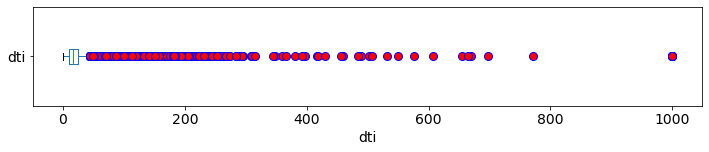

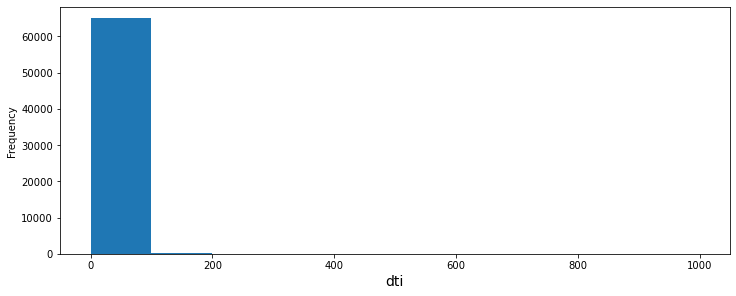



Box plot and histogram for dti after capping the outliers:



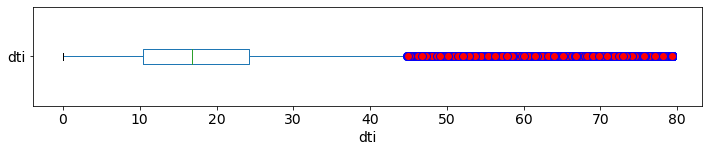

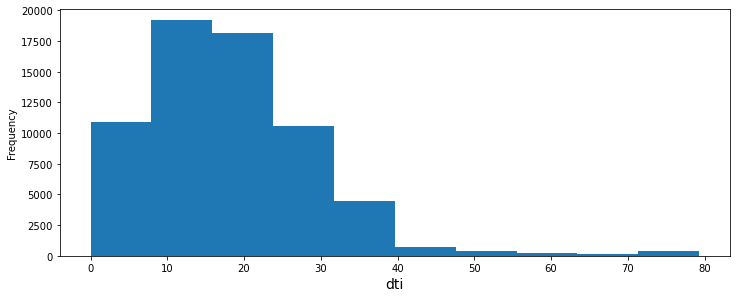


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for dti : 0.0
Maximum value for dti : 79.30430291323465


The lower limit for revol_util is: -36.958256555339425
The upper limit for revol_util is: 116.97976474197944


Box plot and histogram for revol_util before capping the outliers:



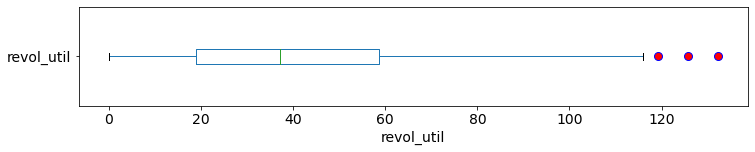

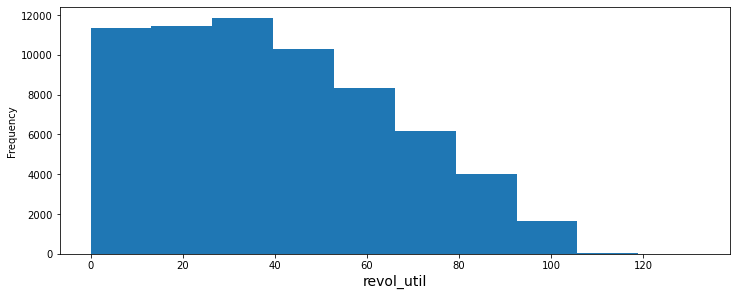



Box plot and histogram for revol_util after capping the outliers:



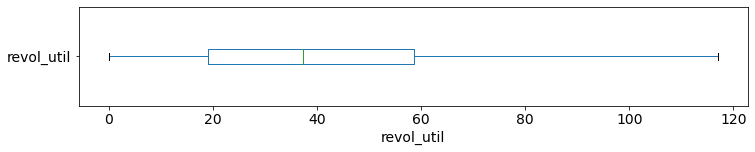

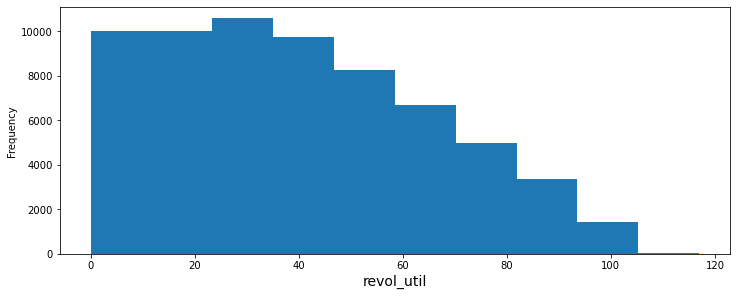


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for revol_util : 0.0
Maximum value for revol_util : 116.97976474197944


The lower limit for avg_cur_bal is: -40203.95032254748
The upper limit for avg_cur_bal is: 69545.5391078812


Box plot and histogram for avg_cur_bal before capping the outliers:



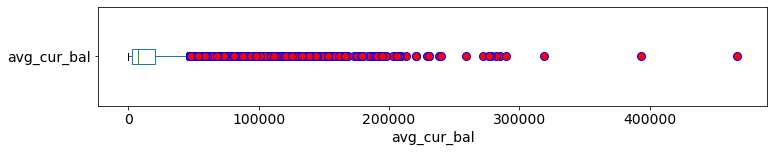

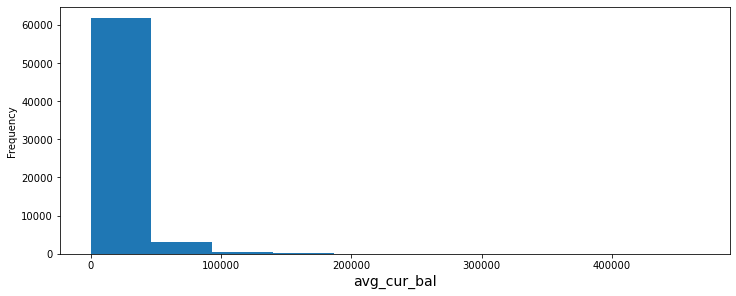



Box plot and histogram for avg_cur_bal after capping the outliers:



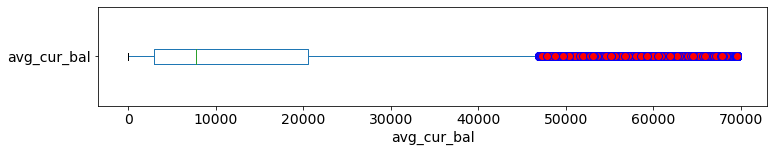

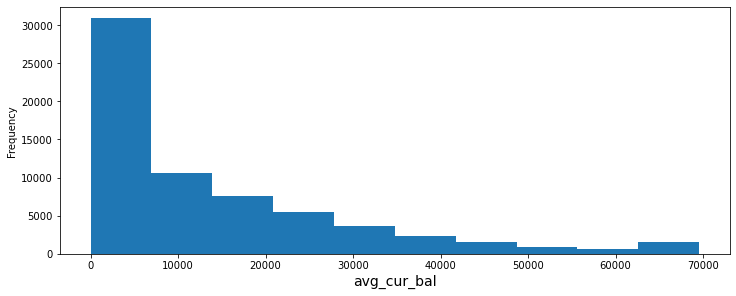


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for avg_cur_bal : 0.0
Maximum value for avg_cur_bal : 69545.5391078812


The lower limit for bc_open_to_buy is: -45153.17043403283
The upper limit for bc_open_to_buy is: 76662.8845144926


Box plot and histogram for bc_open_to_buy before capping the outliers:



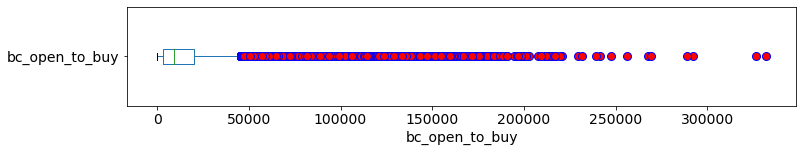

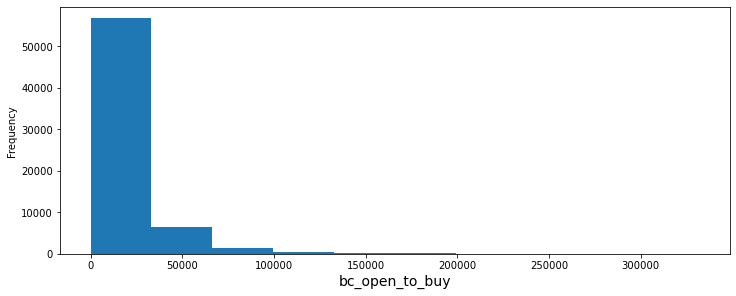



Box plot and histogram for bc_open_to_buy after capping the outliers:



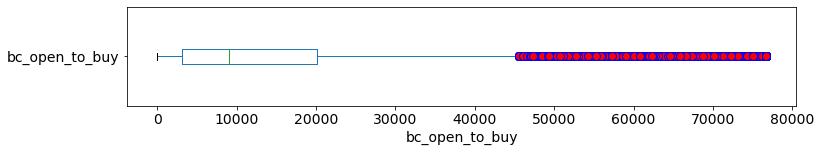

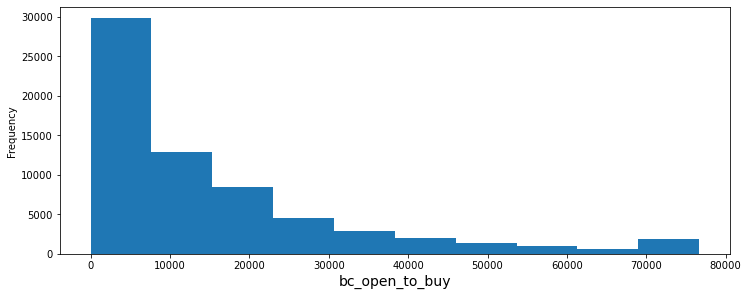


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for bc_open_to_buy : 0.0
Maximum value for bc_open_to_buy : 76662.8845144926


The lower limit for bc_util is: -44.05067931612251
The upper limit for bc_util is: 134.89859842469144


Box plot and histogram for bc_util before capping the outliers:



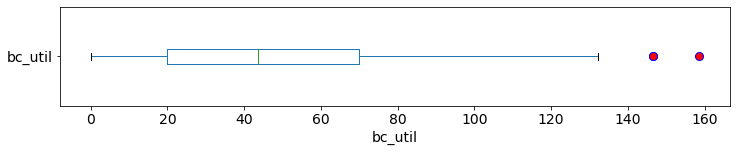

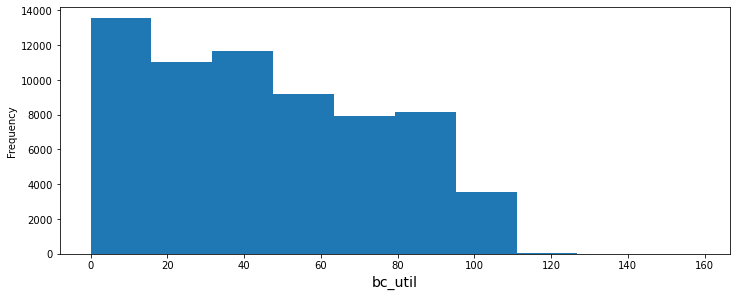



Box plot and histogram for bc_util after capping the outliers:



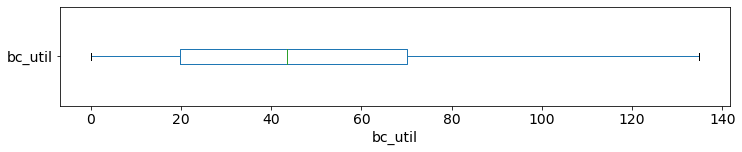

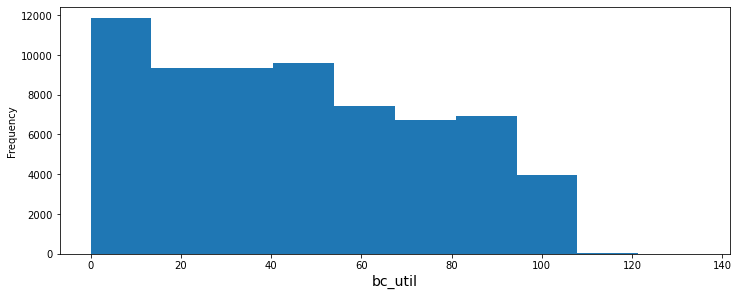


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for bc_util : 0.0
Maximum value for bc_util : 134.89859842469144


The lower limit for pct_tl_nvr_dlq is: 67.96956335948828
The upper limit for pct_tl_nvr_dlq is: 121.35044155346044


Box plot and histogram for pct_tl_nvr_dlq before capping the outliers:



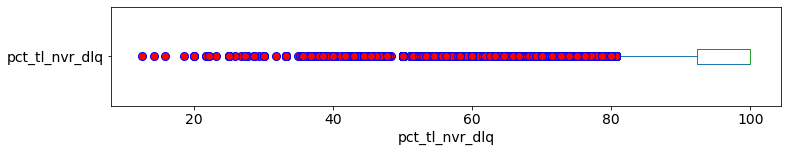

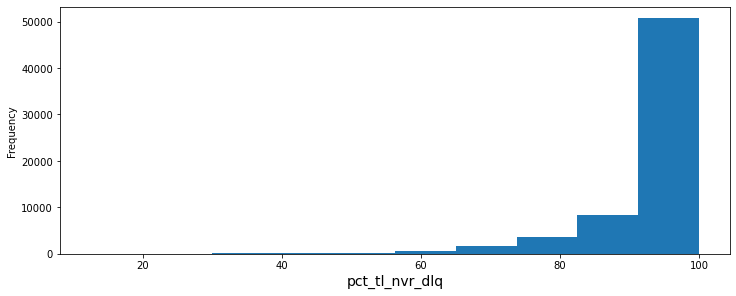



Box plot and histogram for pct_tl_nvr_dlq after capping the outliers:



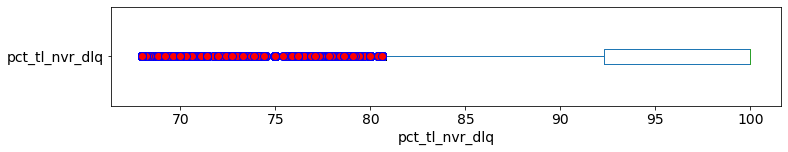

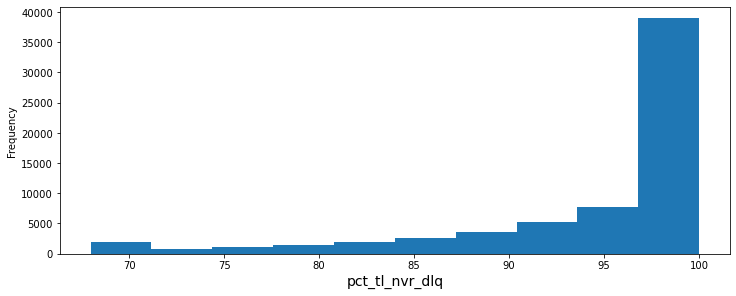


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for pct_tl_nvr_dlq : 67.96956335948828
Maximum value for pct_tl_nvr_dlq : 100.0


The lower limit for percent_bc_gt_75 is: -72.54030648481793
The upper limit for percent_bc_gt_75 is: 132.07669667082158


Box plot and histogram for percent_bc_gt_75 before capping the outliers:



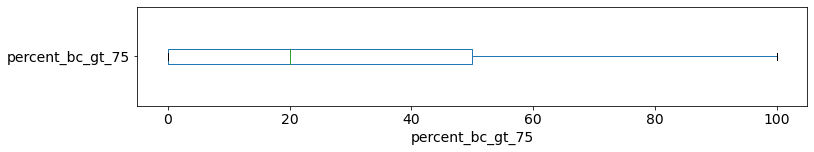

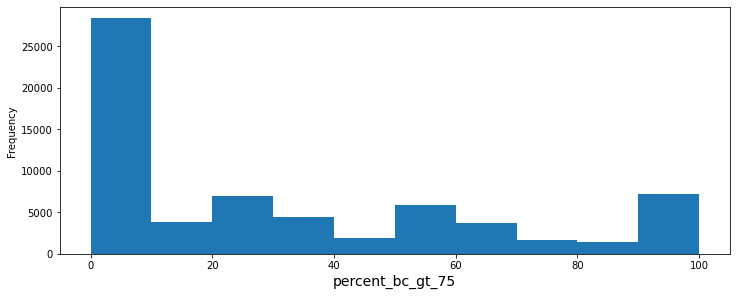



Box plot and histogram for percent_bc_gt_75 after capping the outliers:



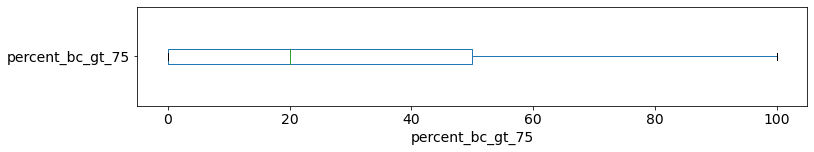

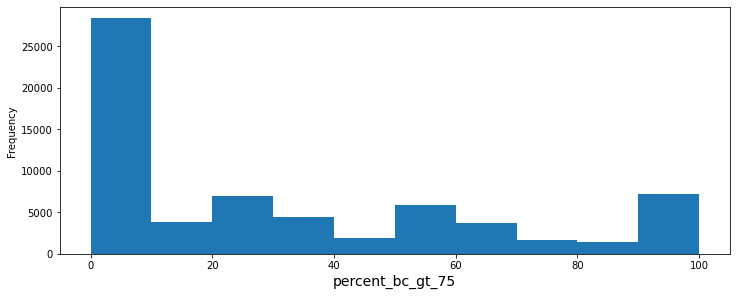


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for percent_bc_gt_75 : 0.0
Maximum value for percent_bc_gt_75 : 100.0


The lower limit for revol_bal_joint is: 1481.2905767305856
The upper limit for revol_bal_joint is: 66017.40782100736


Box plot and histogram for revol_bal_joint before capping the outliers:



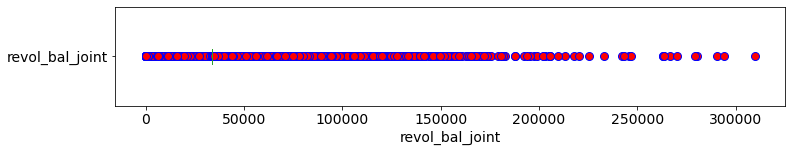

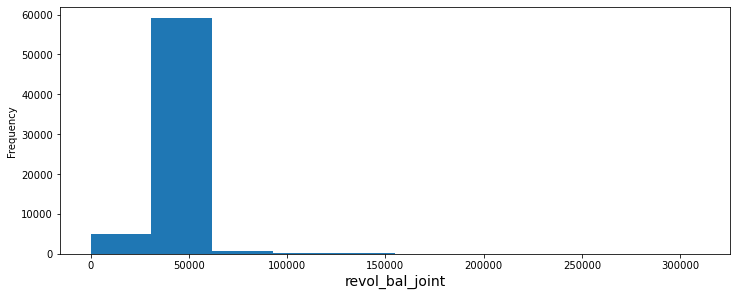



Box plot and histogram for revol_bal_joint after capping the outliers:



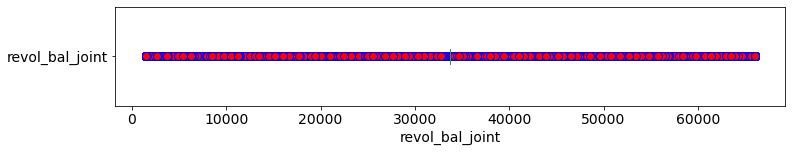

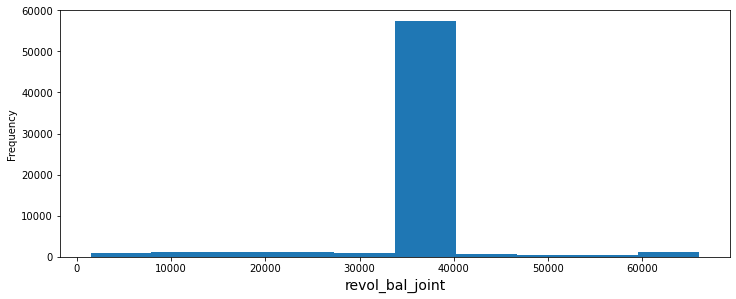


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for revol_bal_joint : 1481.2905767305856
Maximum value for revol_bal_joint : 66017.40782100736


The lower limit for hardship_amount is: 160.43422147639433
The upper limit for hardship_amount is: 210.11569587897748


Box plot and histogram for hardship_amount before capping the outliers:



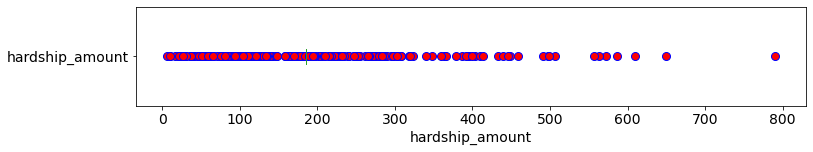

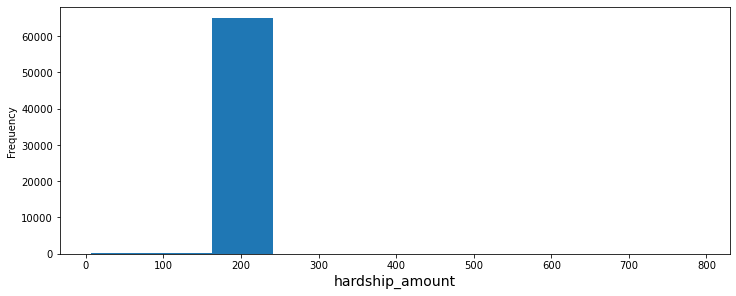



Box plot and histogram for hardship_amount after capping the outliers:



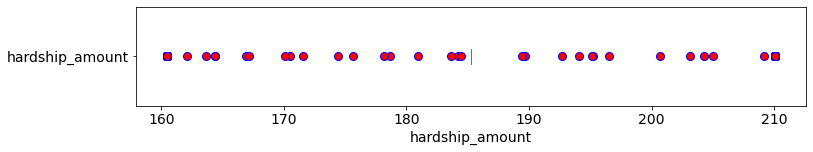

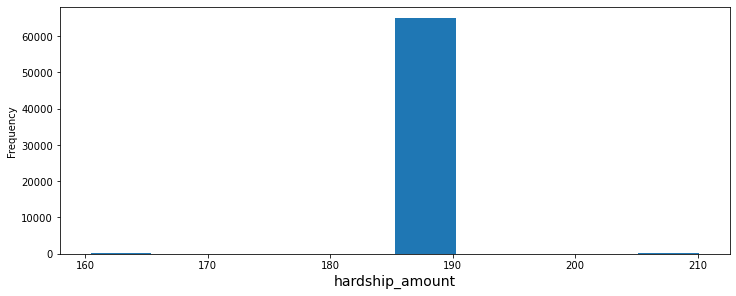


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for hardship_amount : 160.43422147639433
Maximum value for hardship_amount : 210.11569587897748


The lower limit for orig_projected_additional_accrued_interest is: 482.3689354454615
The upper limit for orig_projected_additional_accrued_interest is: 619.740612293232


Box plot and histogram for orig_projected_additional_accrued_interest before capping the outliers:



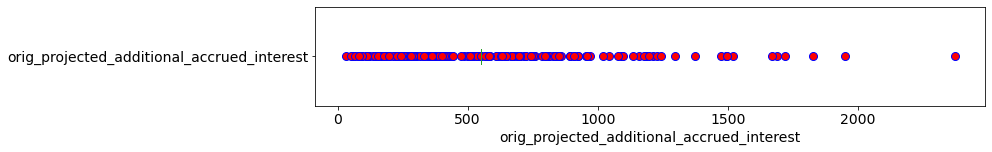

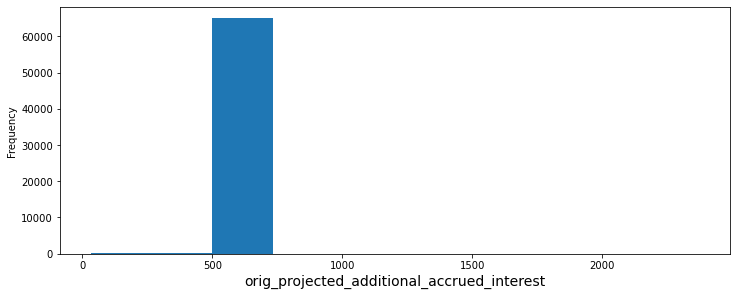



Box plot and histogram for orig_projected_additional_accrued_interest after capping the outliers:



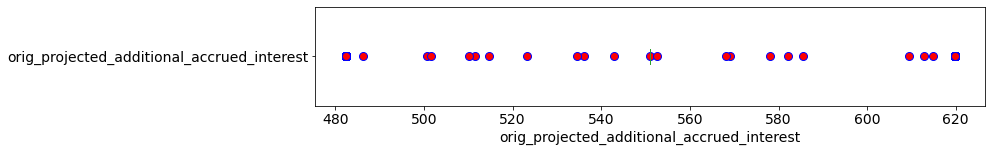

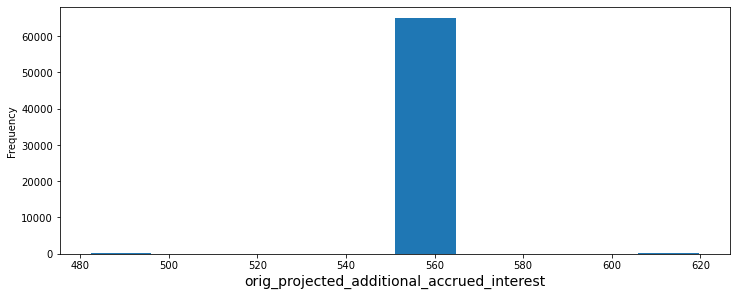


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for orig_projected_additional_accrued_interest : 482.3689354454615
Maximum value for orig_projected_additional_accrued_interest : 619.740612293232


The lower limit for hardship_payoff_balance_amount is: 13171.738047138735
The upper limit for hardship_payoff_balance_amount is: 16348.740465257955


Box plot and histogram for hardship_payoff_balance_amount before capping the outliers:



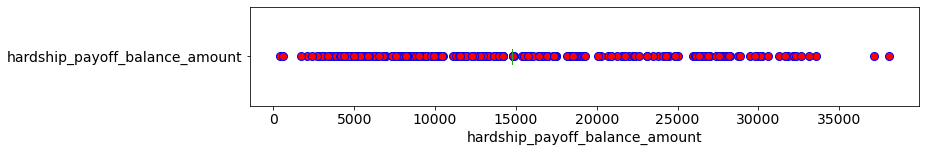

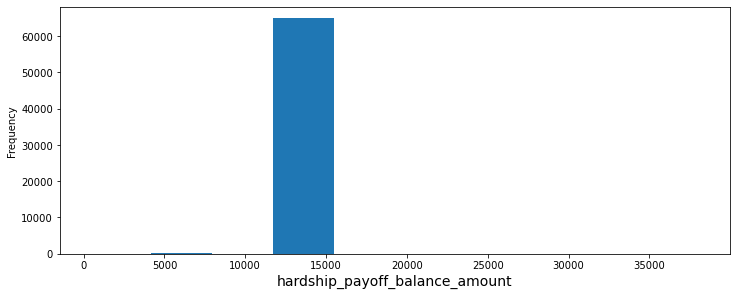



Box plot and histogram for hardship_payoff_balance_amount after capping the outliers:



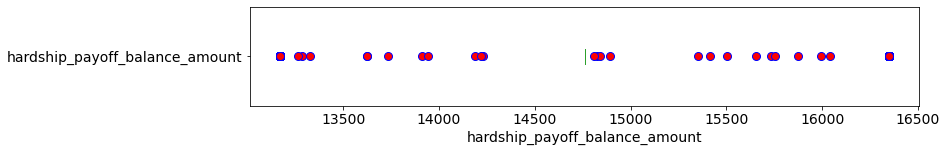

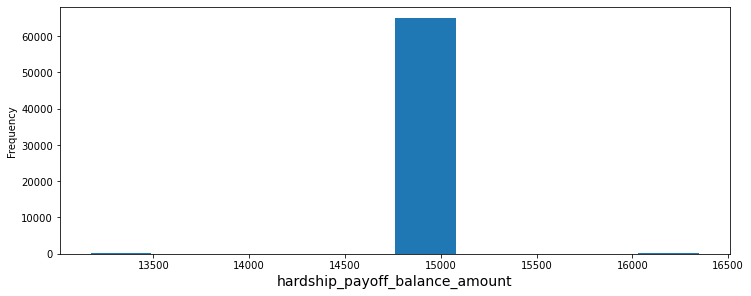


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for hardship_payoff_balance_amount : 13171.738047138735
Maximum value for hardship_payoff_balance_amount : 16348.740465257955


The lower limit for hardship_last_payment_amount is: 183.789769158264
The upper limit for hardship_last_payment_amount is: 262.1878341475211


Box plot and histogram for hardship_last_payment_amount before capping the outliers:



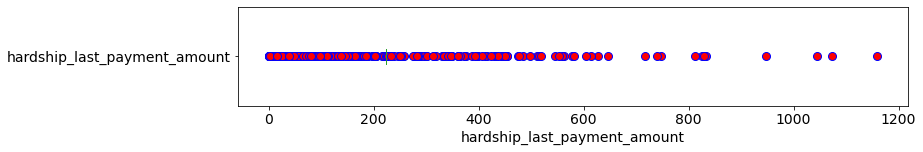

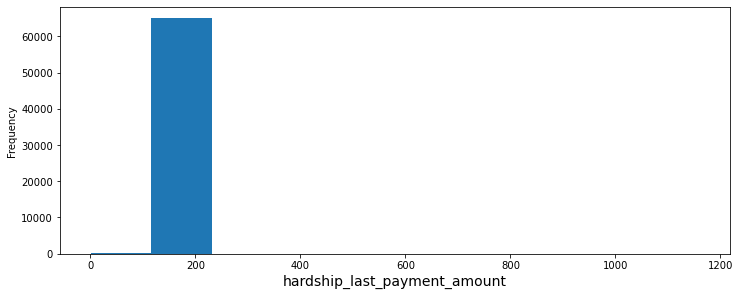



Box plot and histogram for hardship_last_payment_amount after capping the outliers:



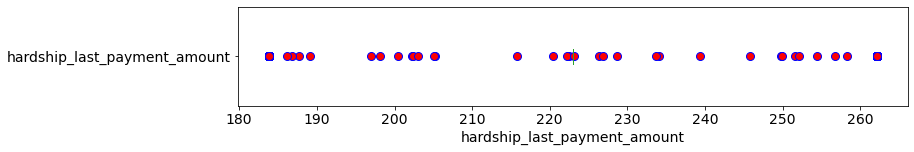

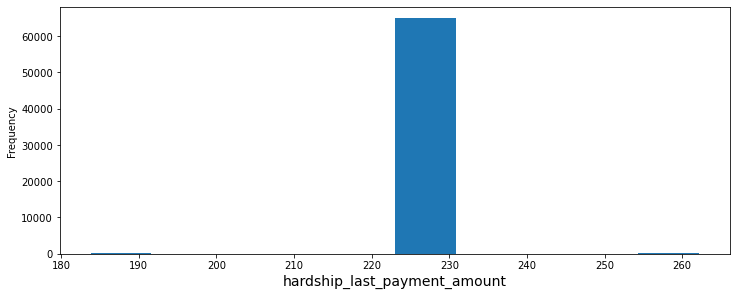


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for hardship_last_payment_amount : 183.789769158264
Maximum value for hardship_last_payment_amount : 262.1878341475211


The lower limit for settlement_amount is: 5948.750606993357
The upper limit for settlement_amount is: 8514.888968378189


Box plot and histogram for settlement_amount before capping the outliers:



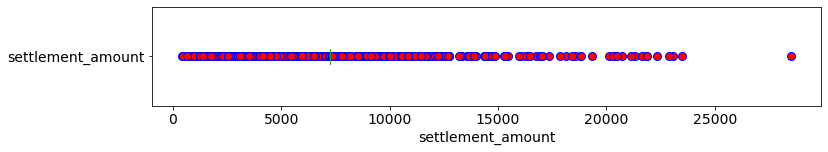

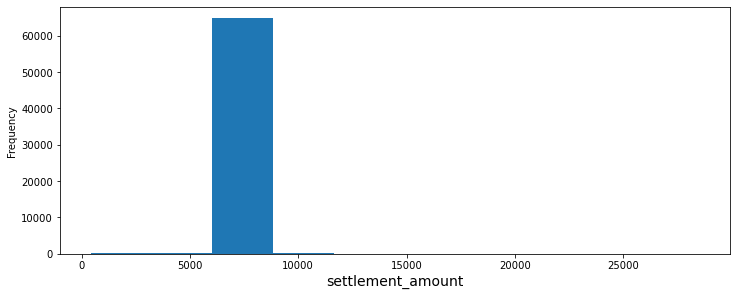



Box plot and histogram for settlement_amount after capping the outliers:



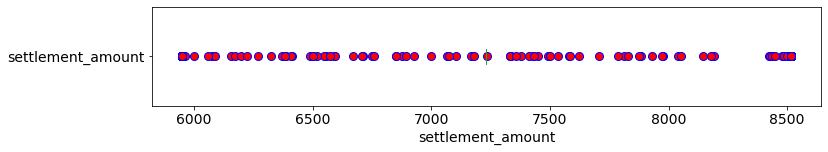

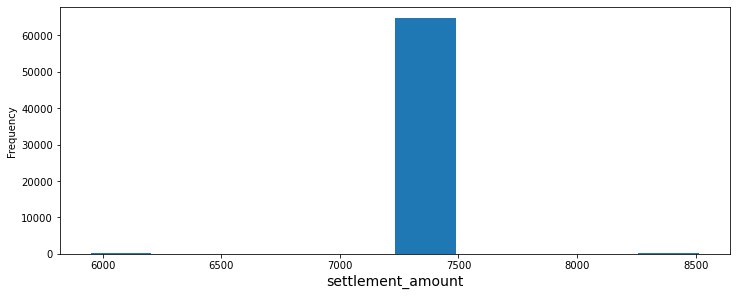


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for settlement_amount : 5948.750606993357
Maximum value for settlement_amount : 8514.888968378189


The lower limit for StateLaborForceParticipationRate is: 54.453643611365585
The upper limit for StateLaborForceParticipationRate is: 70.99434539258611


Box plot and histogram for StateLaborForceParticipationRate before capping the outliers:



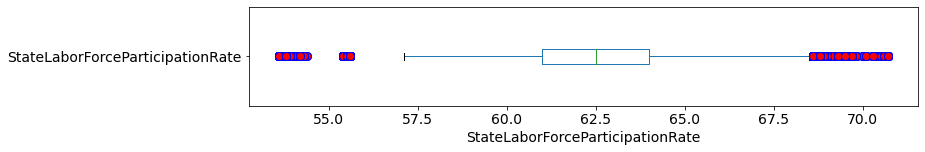

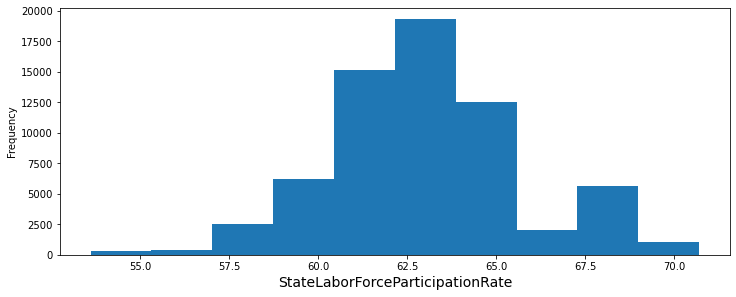



Box plot and histogram for StateLaborForceParticipationRate after capping the outliers:



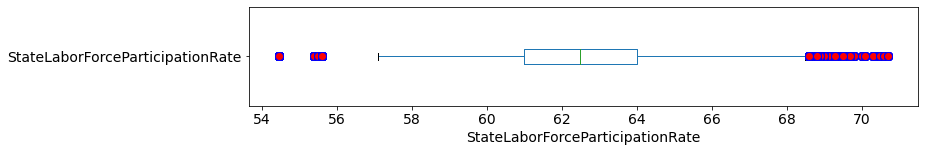

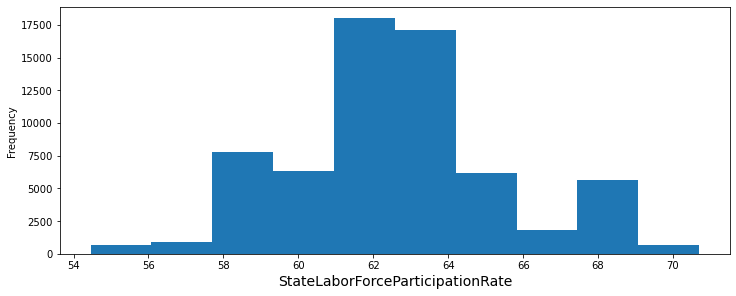


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for StateLaborForceParticipationRate : 54.453643611365585
Maximum value for StateLaborForceParticipationRate : 70.7


The lower limit for StateEmploymentPopulationRatio is: 51.820273238855094
The upper limit for StateEmploymentPopulationRatio is: 68.63769655325086


Box plot and histogram for StateEmploymentPopulationRatio before capping the outliers:



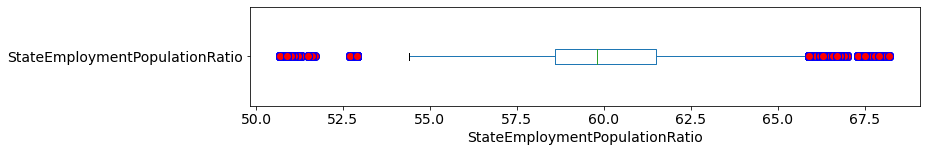

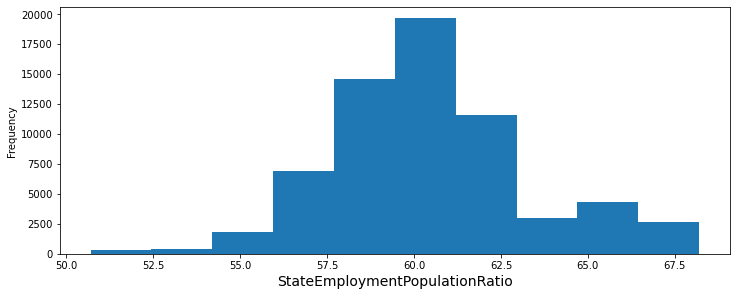



Box plot and histogram for StateEmploymentPopulationRatio after capping the outliers:



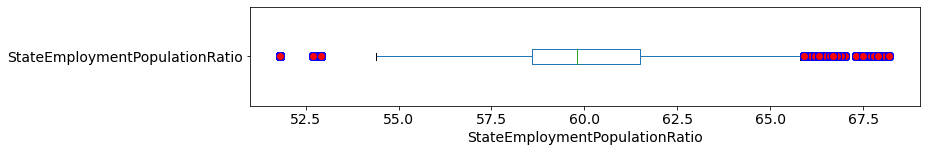

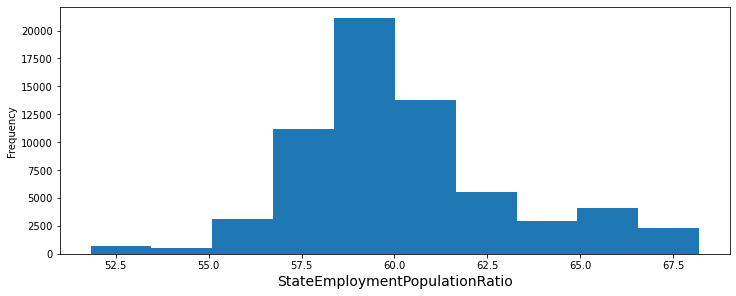


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for StateEmploymentPopulationRatio : 51.820273238855094
Maximum value for StateEmploymentPopulationRatio : 68.2


The lower limit for StateUnemploymentRate is: 2.4447393549201983
The upper limit for StateUnemploymentRate is: 5.54236527935186


Box plot and histogram for StateUnemploymentRate before capping the outliers:



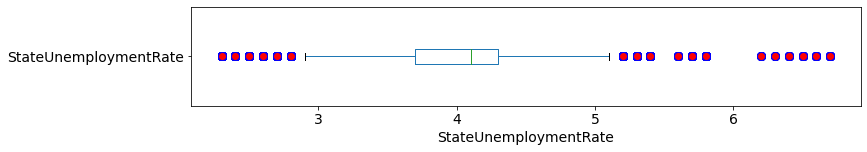

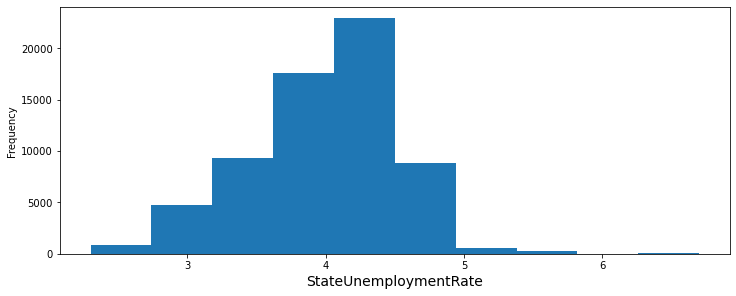



Box plot and histogram for StateUnemploymentRate after capping the outliers:



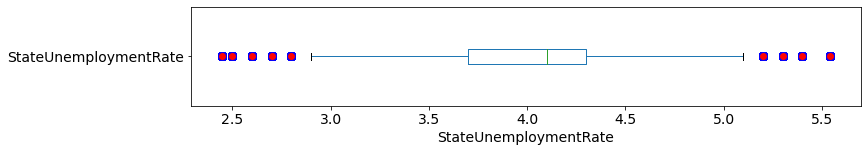

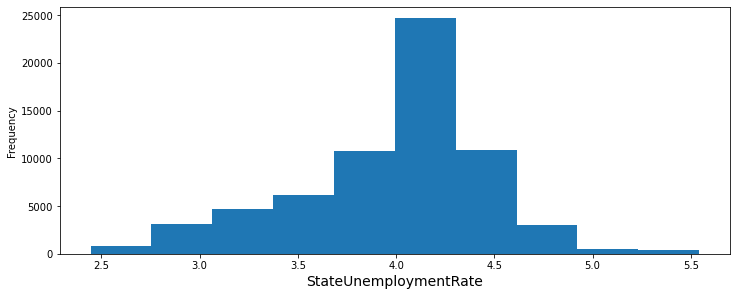


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for StateUnemploymentRate : 2.4447393549201983
Maximum value for StateUnemploymentRate : 5.54236527935186


The lower limit for mths_since_last_delinq is: -9.01291515722506
The upper limit for mths_since_last_delinq is: 79.37496321126667


Box plot and histogram for mths_since_last_delinq before capping the outliers:



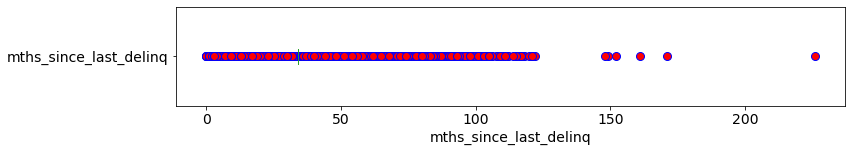

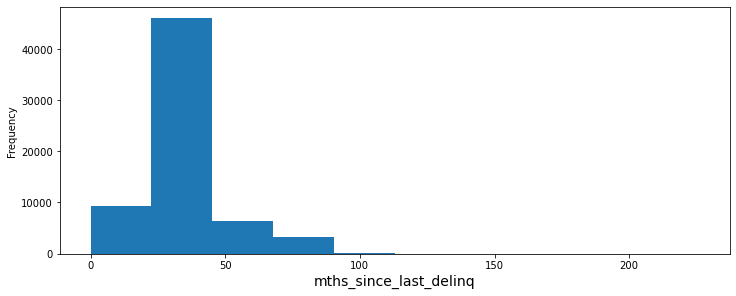



Box plot and histogram for mths_since_last_delinq after capping the outliers:



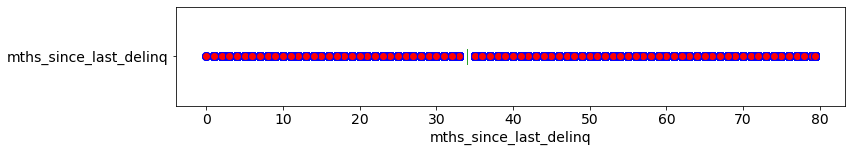

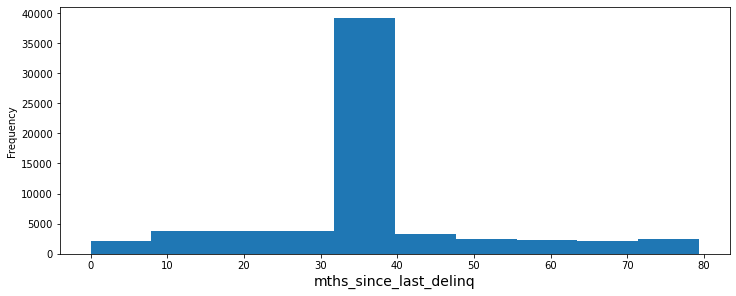


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_last_delinq : 0.0
Maximum value for mths_since_last_delinq : 79.37496321126667


The lower limit for mths_since_last_record is: 57.65478218042814
The upper limit for mths_since_last_record is: 113.2360138585678


Box plot and histogram for mths_since_last_record before capping the outliers:



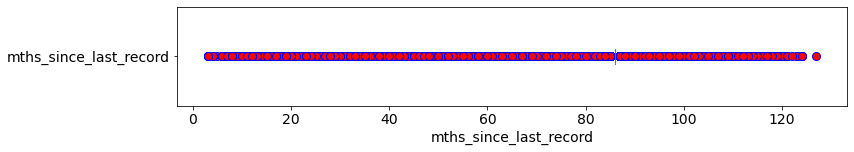

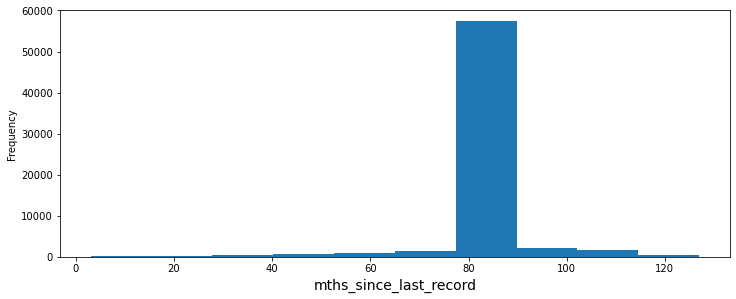



Box plot and histogram for mths_since_last_record after capping the outliers:



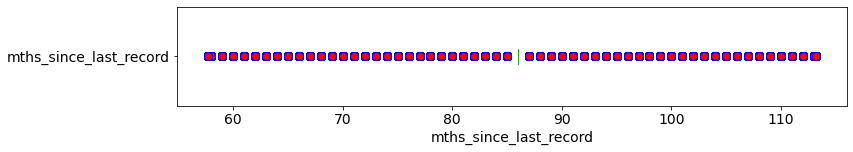

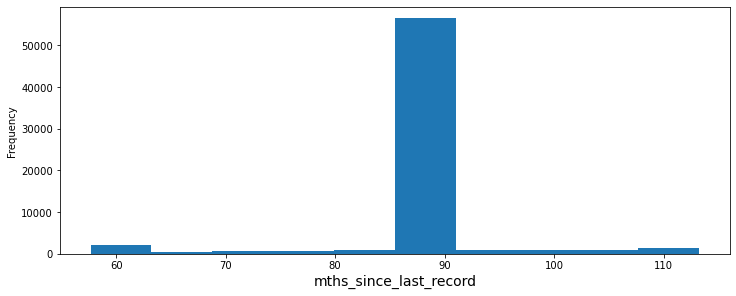


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_last_record : 57.65478218042814
Maximum value for mths_since_last_record : 113.2360138585678


The lower limit for mths_since_last_major_derog is: 13.942730684568367
The upper limit for mths_since_last_major_derog is: 77.9935861957571


Box plot and histogram for mths_since_last_major_derog before capping the outliers:



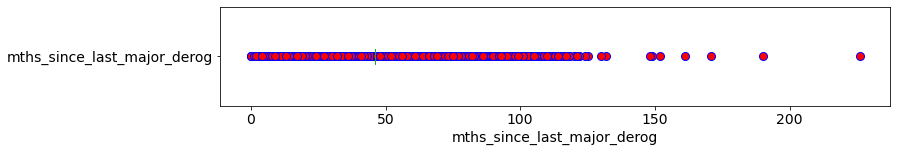

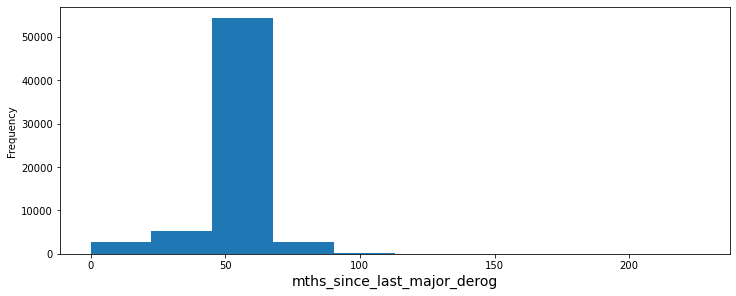



Box plot and histogram for mths_since_last_major_derog after capping the outliers:



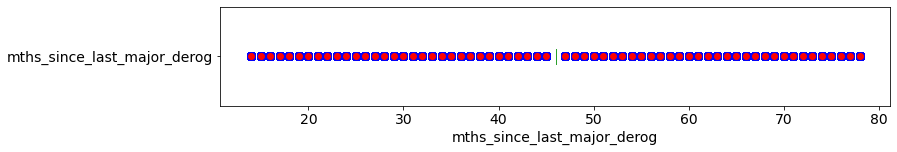

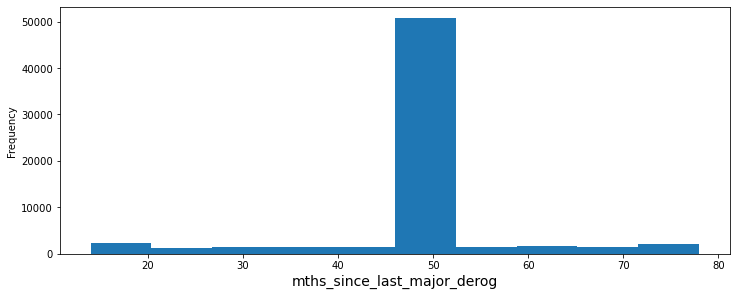


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_last_major_derog : 13.942730684568367
Maximum value for mths_since_last_major_derog : 77.9935861957571


The lower limit for annual_inc_joint is: 33534.53614565794
The upper limit for annual_inc_joint is: 190860.75092642312


Box plot and histogram for annual_inc_joint before capping the outliers:



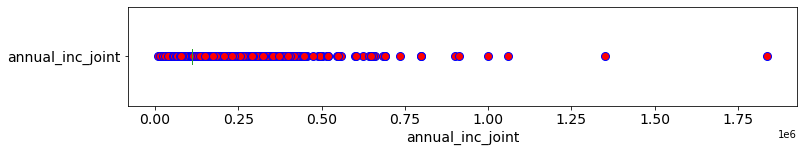

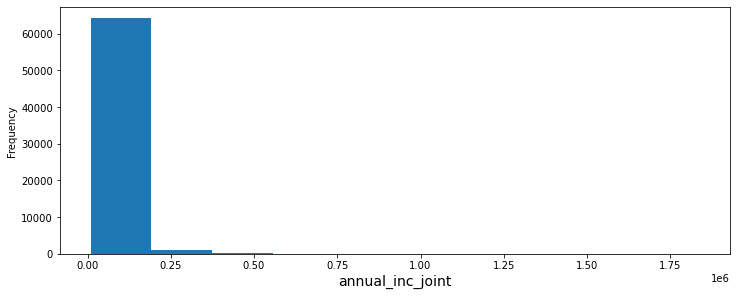



Box plot and histogram for annual_inc_joint after capping the outliers:



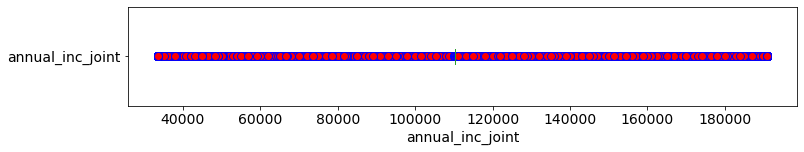

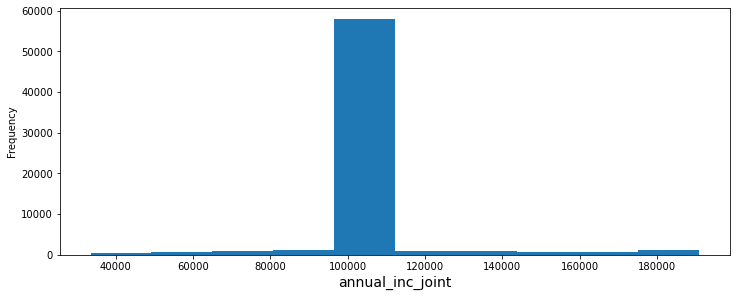


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for annual_inc_joint : 33534.53614565794
Maximum value for annual_inc_joint : 190860.75092642312


The lower limit for dti_joint is: 9.670862536736818
The upper limit for dti_joint is: 27.707306496808897


Box plot and histogram for dti_joint before capping the outliers:



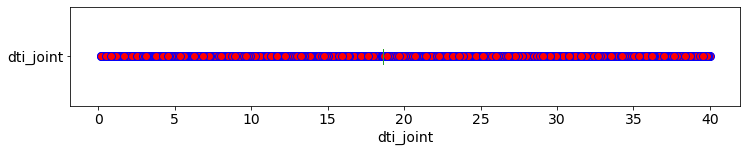

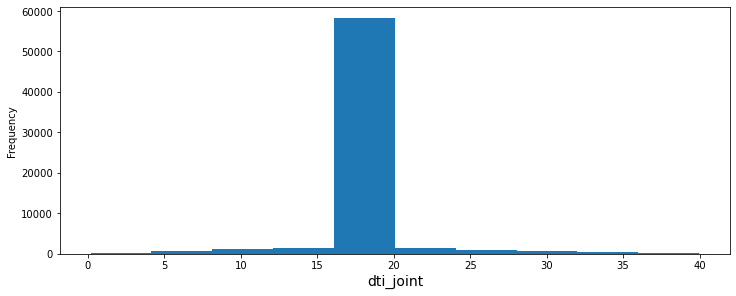



Box plot and histogram for dti_joint after capping the outliers:



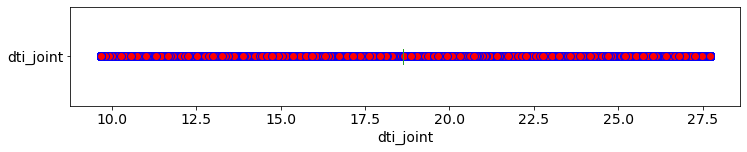

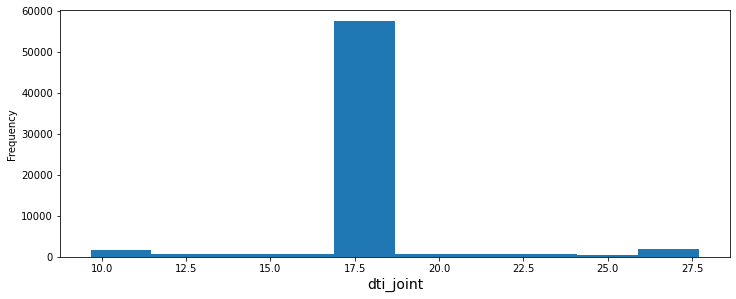


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for dti_joint : 9.670862536736818
Maximum value for dti_joint : 27.707306496808897


The lower limit for mths_since_rcnt_il is: -52.068771820177616
The upper limit for mths_since_rcnt_il is: 87.90007603450171


Box plot and histogram for mths_since_rcnt_il before capping the outliers:



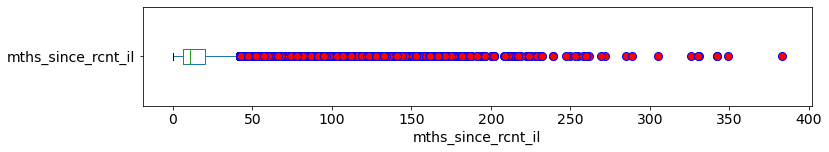

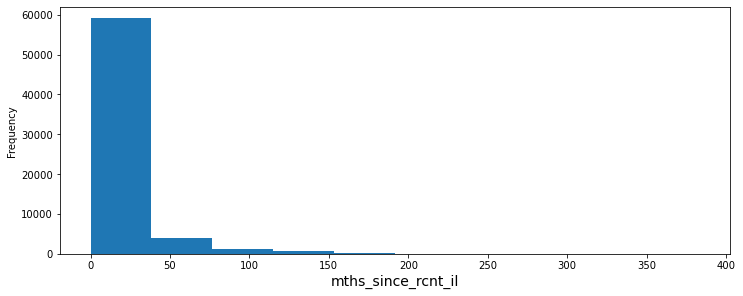



Box plot and histogram for mths_since_rcnt_il after capping the outliers:



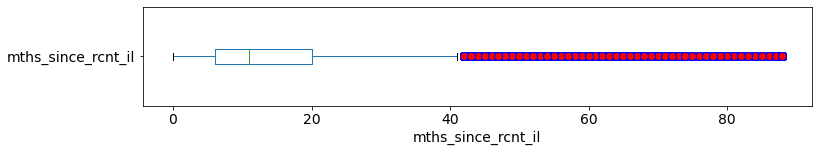

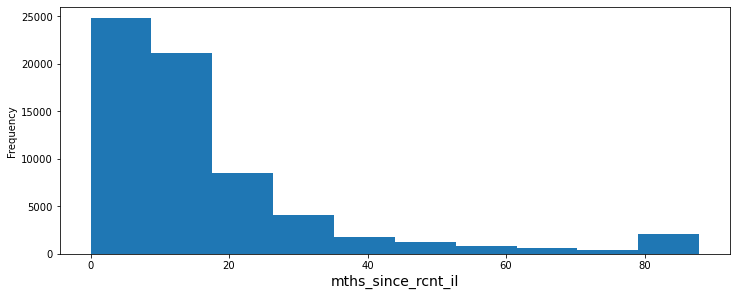


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_rcnt_il : 0.0
Maximum value for mths_since_rcnt_il : 87.90007603450171


The lower limit for il_util is: 9.601590980021854
The upper limit for il_util is: 133.95916744478816


Box plot and histogram for il_util before capping the outliers:



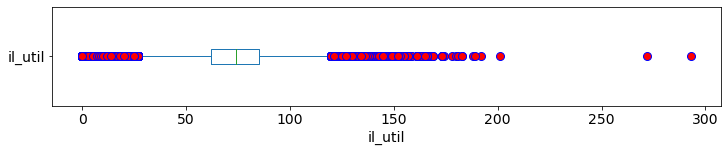

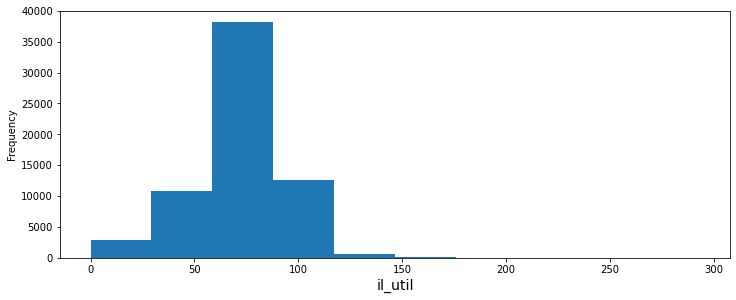



Box plot and histogram for il_util after capping the outliers:



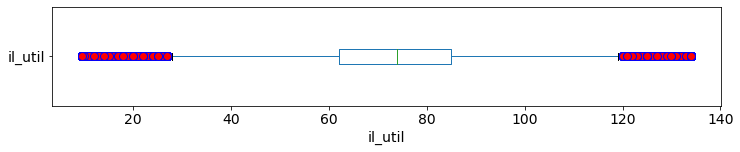

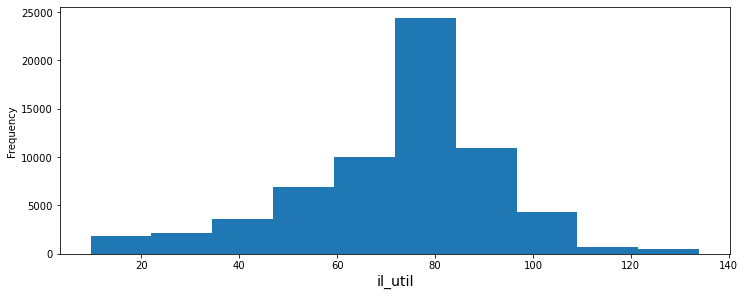


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for il_util : 9.601590980021854
Maximum value for il_util : 133.95916744478816


The lower limit for all_util is: -13.812967146015723
The upper limit for all_util is: 119.5925633692444


Box plot and histogram for all_util before capping the outliers:



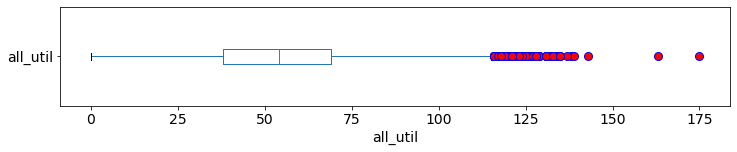

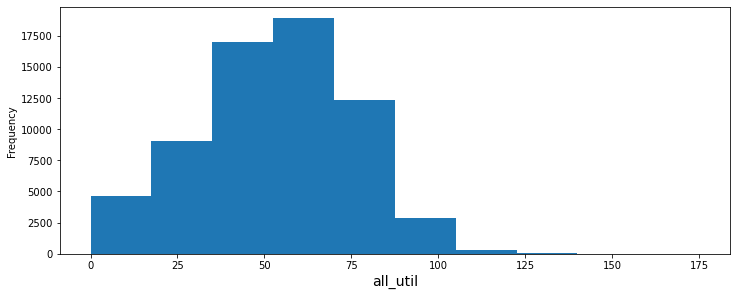



Box plot and histogram for all_util after capping the outliers:



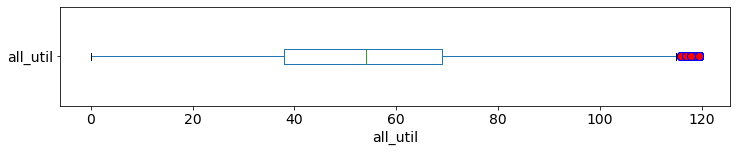

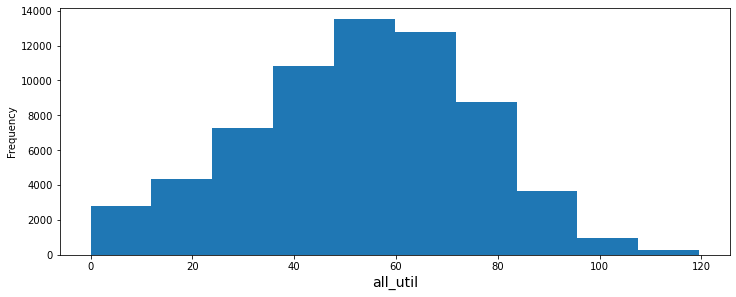


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for all_util : 0.0
Maximum value for all_util : 119.5925633692444


The lower limit for mo_sin_old_il_acct is: -41.45508260931024
The upper limit for mo_sin_old_il_acct is: 283.4576618677734


Box plot and histogram for mo_sin_old_il_acct before capping the outliers:



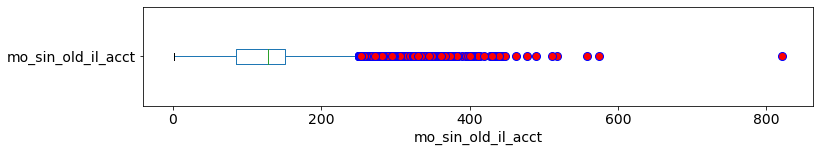

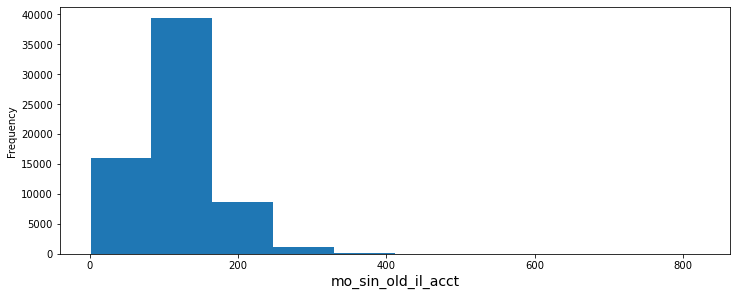



Box plot and histogram for mo_sin_old_il_acct after capping the outliers:



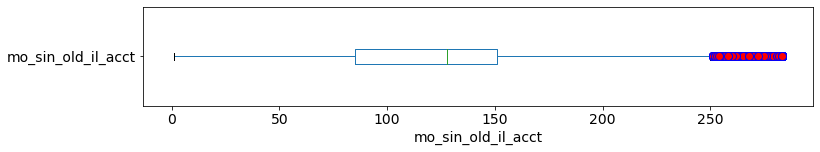

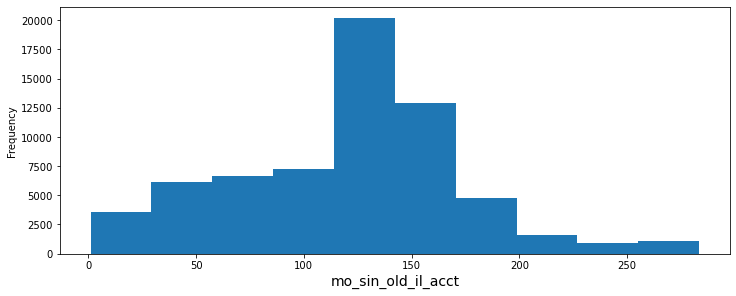


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mo_sin_old_il_acct : 1.0
Maximum value for mo_sin_old_il_acct : 283.4576618677734


The lower limit for mths_since_recent_bc is: -73.07493182979707
The upper limit for mths_since_recent_bc is: 119.16152122106135


Box plot and histogram for mths_since_recent_bc before capping the outliers:



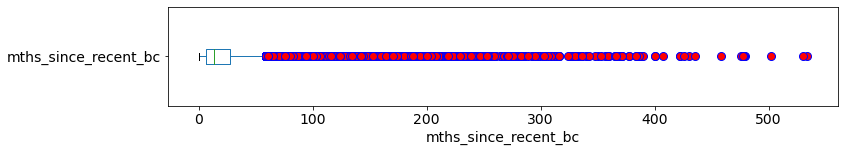

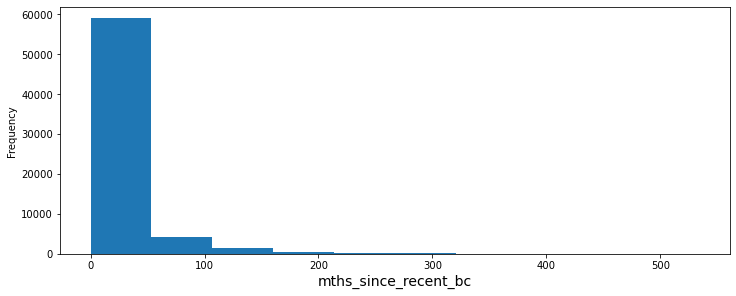



Box plot and histogram for mths_since_recent_bc after capping the outliers:



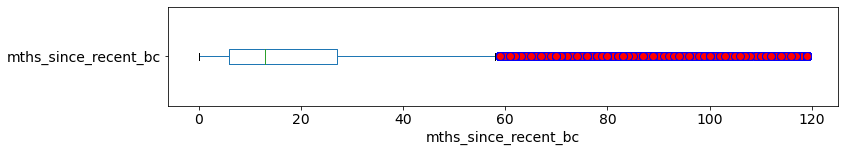

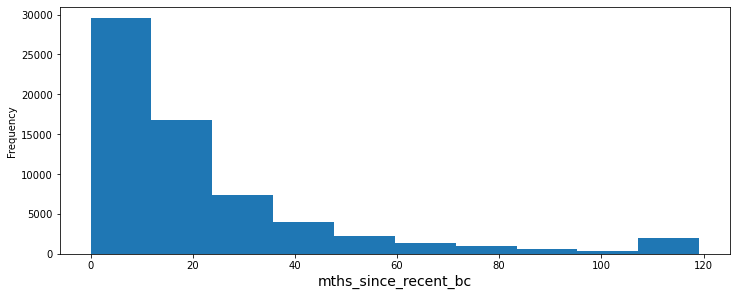


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_recent_bc : 0.0
Maximum value for mths_since_recent_bc : 119.16152122106135


The lower limit for mths_since_recent_bc_dlq is: 8.989951499619877
The upper limit for mths_since_recent_bc_dlq is: 69.57819158781392


Box plot and histogram for mths_since_recent_bc_dlq before capping the outliers:



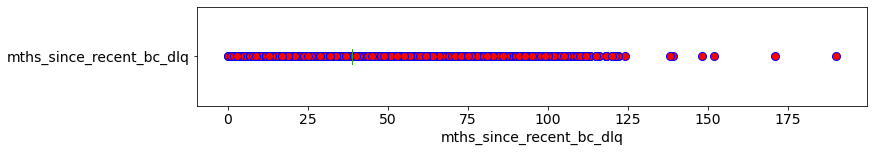

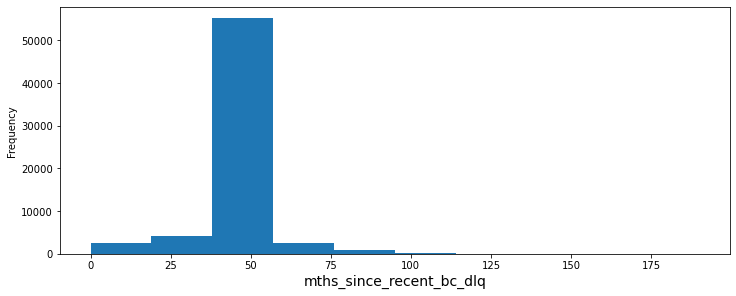



Box plot and histogram for mths_since_recent_bc_dlq after capping the outliers:



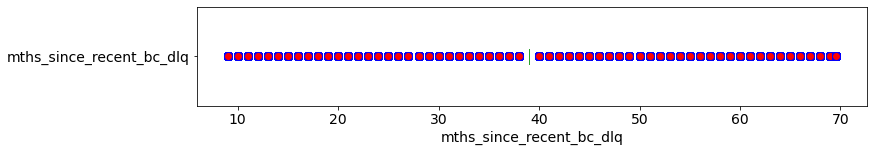

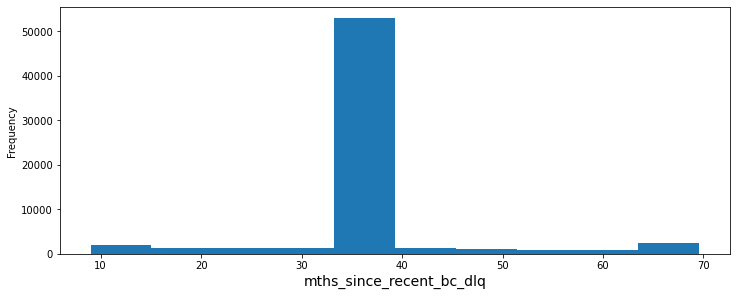


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_recent_bc_dlq : 8.989951499619877
Maximum value for mths_since_recent_bc_dlq : 69.57819158781392


The lower limit for mths_since_recent_inq is: -9.978055635183548
The upper limit for mths_since_recent_inq is: 22.674486125703236


Box plot and histogram for mths_since_recent_inq before capping the outliers:



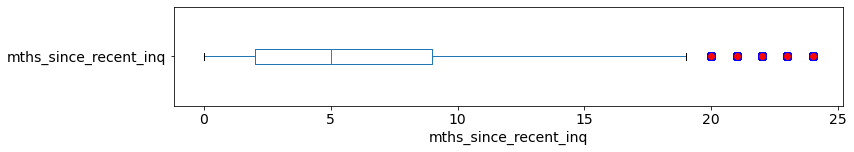

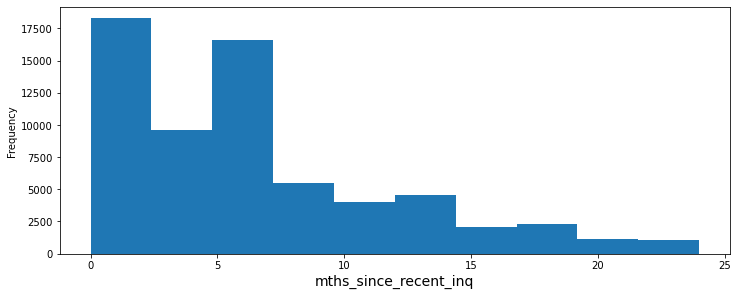



Box plot and histogram for mths_since_recent_inq after capping the outliers:



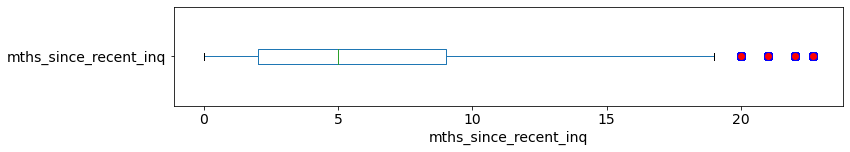

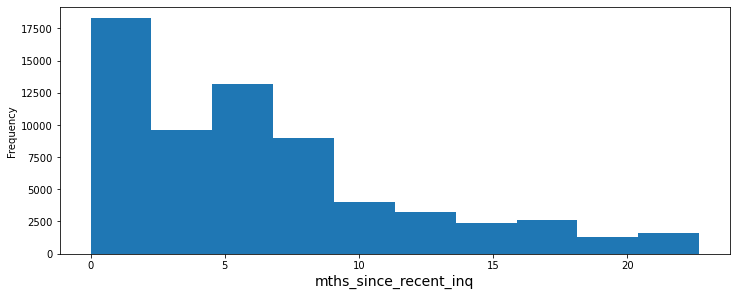


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_recent_inq : 0.0
Maximum value for mths_since_recent_inq : 22.674486125703236


The lower limit for mths_since_recent_revol_delinq is: -0.4661124050330443
The upper limit for mths_since_recent_revol_delinq is: 72.01219362096917


Box plot and histogram for mths_since_recent_revol_delinq before capping the outliers:



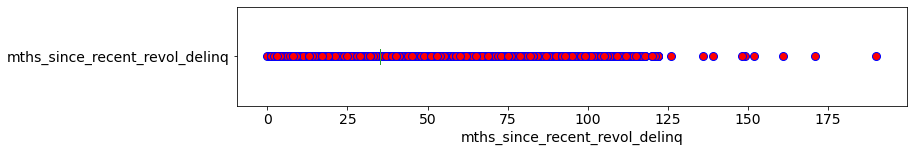

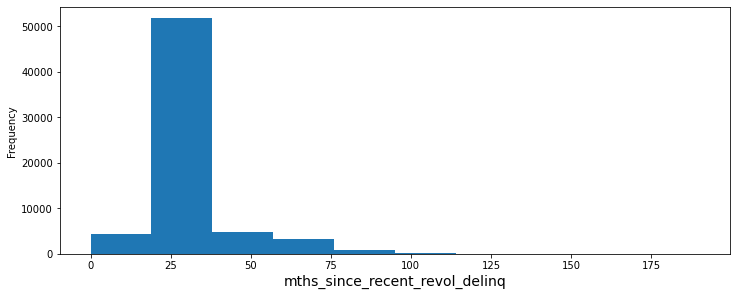



Box plot and histogram for mths_since_recent_revol_delinq after capping the outliers:



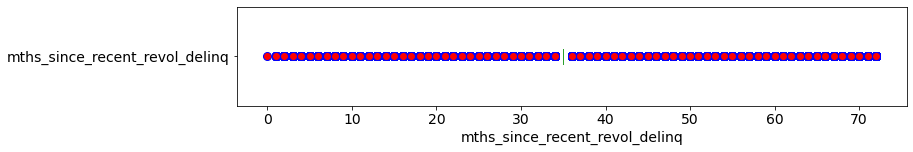

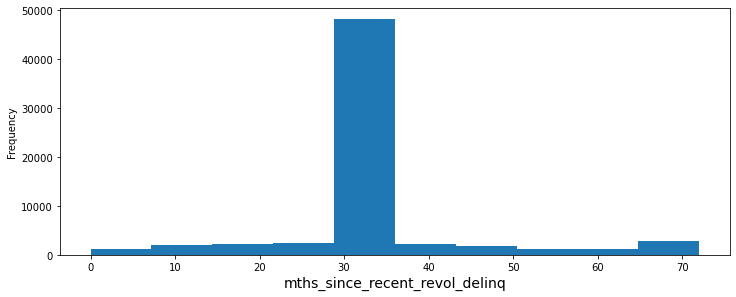


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for mths_since_recent_revol_delinq : 0.0
Maximum value for mths_since_recent_revol_delinq : 72.01219362096917


The lower limit for num_tl_120dpd_2m is: 0.0
The upper limit for num_tl_120dpd_2m is: 0.0


Box plot and histogram for num_tl_120dpd_2m before capping the outliers:



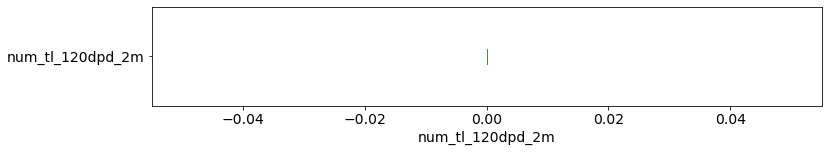

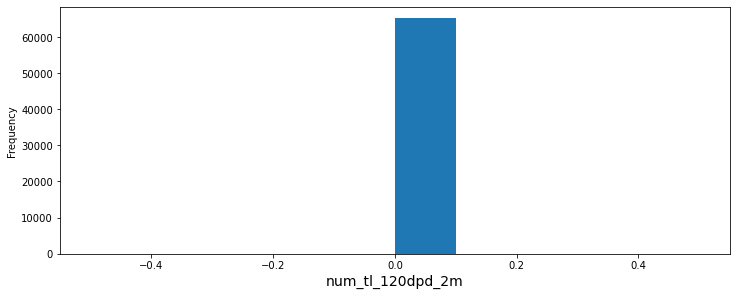



Box plot and histogram for num_tl_120dpd_2m after capping the outliers:



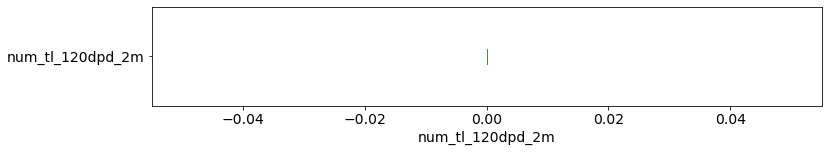

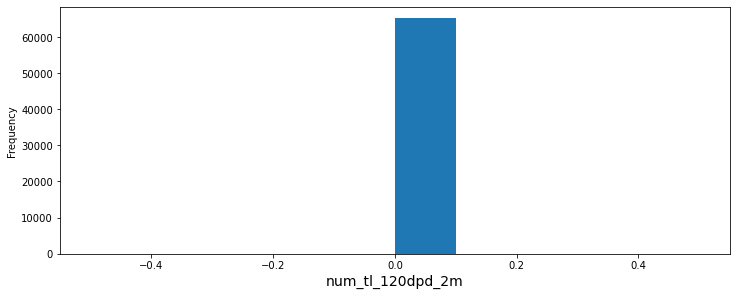


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for num_tl_120dpd_2m : 0.0
Maximum value for num_tl_120dpd_2m : 0.0


The lower limit for sec_app_fico_range_low is: 614.2233676230907
The upper limit for sec_app_fico_range_low is: 716.1289775062561


Box plot and histogram for sec_app_fico_range_low before capping the outliers:



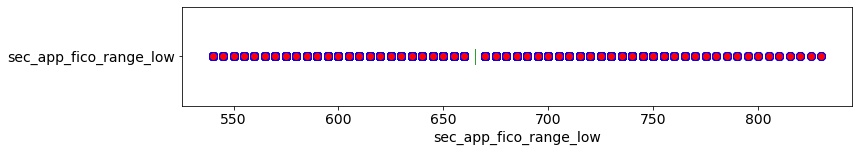

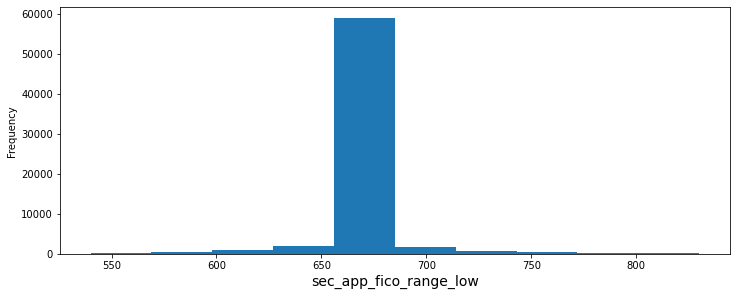



Box plot and histogram for sec_app_fico_range_low after capping the outliers:



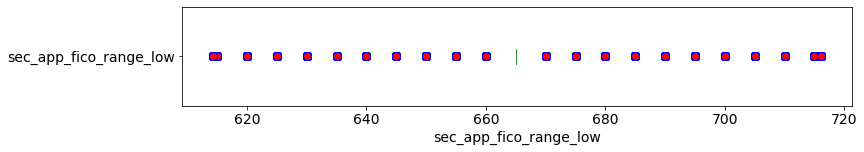

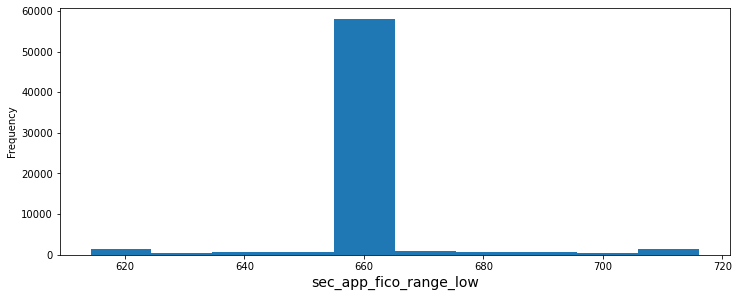


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_fico_range_low : 614.2233676230907
Maximum value for sec_app_fico_range_low : 716.1289775062561


The lower limit for sec_app_fico_range_high is: 618.2233676230907
The upper limit for sec_app_fico_range_high is: 720.1289775062561


Box plot and histogram for sec_app_fico_range_high before capping the outliers:



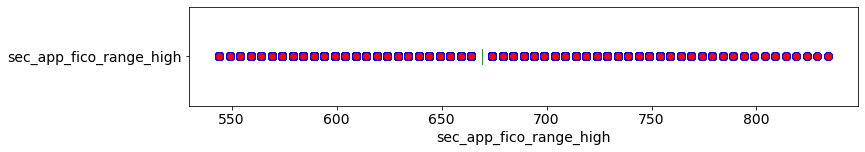

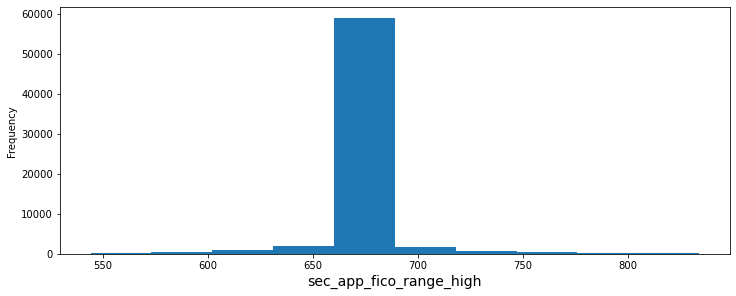



Box plot and histogram for sec_app_fico_range_high after capping the outliers:



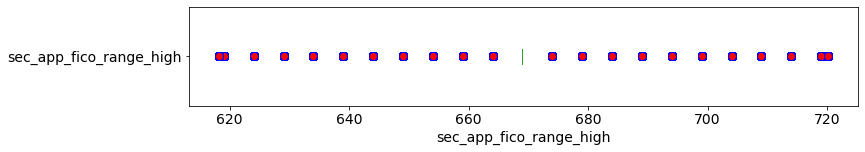

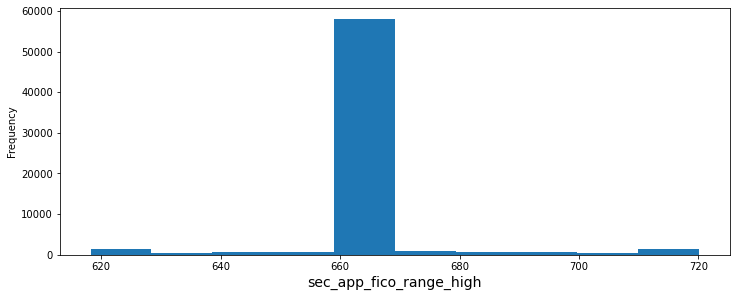


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_fico_range_high : 618.2233676230907
Maximum value for sec_app_fico_range_high : 720.1289775062561


The lower limit for sec_app_inq_last_6mths is: -1.32633505000318
The upper limit for sec_app_inq_last_6mths is: 1.5243852534268387


Box plot and histogram for sec_app_inq_last_6mths before capping the outliers:



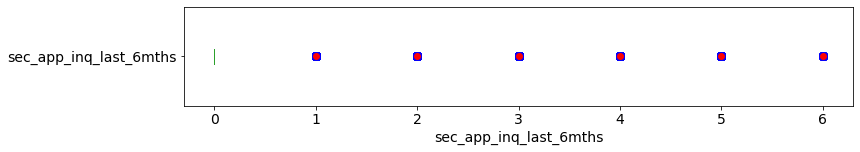

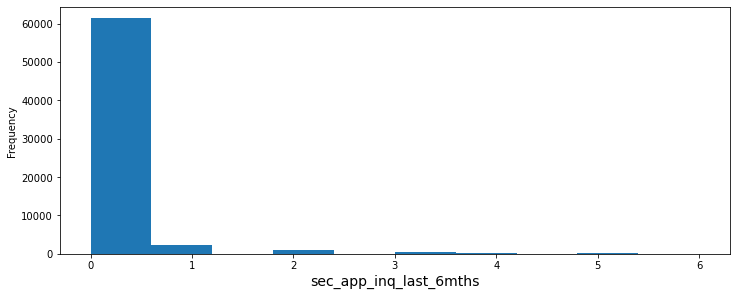



Box plot and histogram for sec_app_inq_last_6mths after capping the outliers:



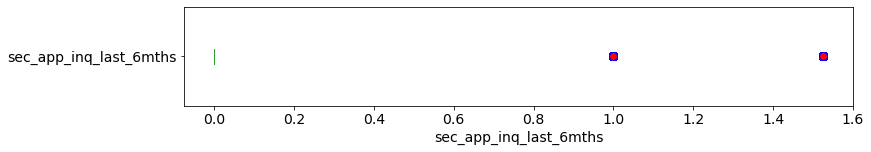

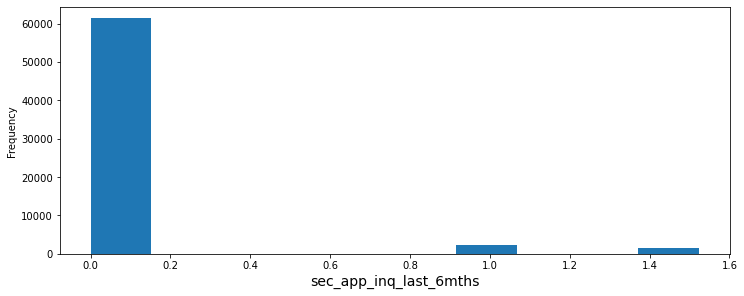


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_inq_last_6mths : 0.0
Maximum value for sec_app_inq_last_6mths : 1.5243852534268387


The lower limit for sec_app_mort_acc is: -1.0106398617901688
The upper limit for sec_app_mort_acc is: 3.174576301492326


Box plot and histogram for sec_app_mort_acc before capping the outliers:



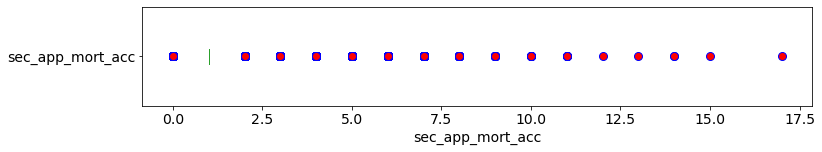

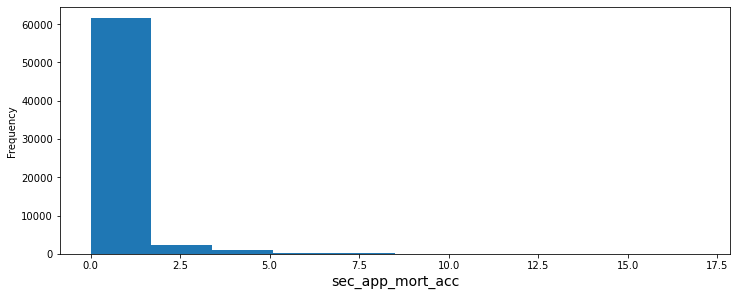



Box plot and histogram for sec_app_mort_acc after capping the outliers:



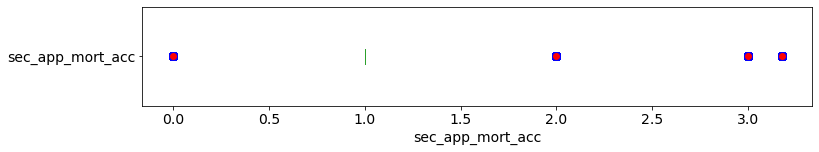

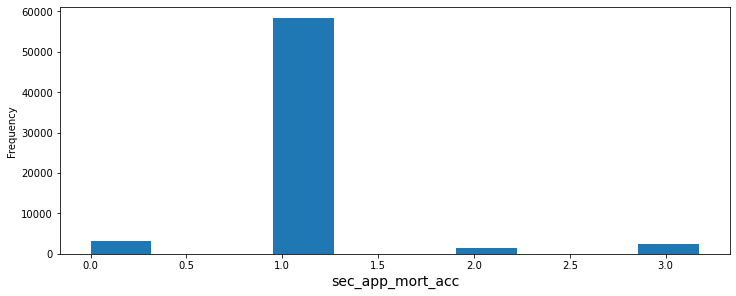


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_mort_acc : 0.0
Maximum value for sec_app_mort_acc : 3.174576301492326


The lower limit for sec_app_open_acc is: 2.9689171920196777
The upper limit for sec_app_open_acc is: 17.370163179516364


Box plot and histogram for sec_app_open_acc before capping the outliers:



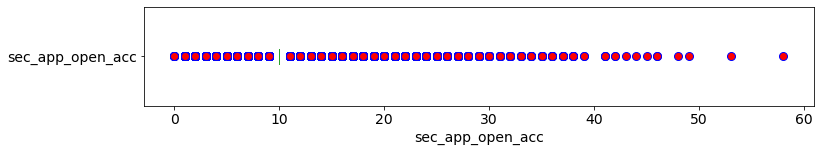

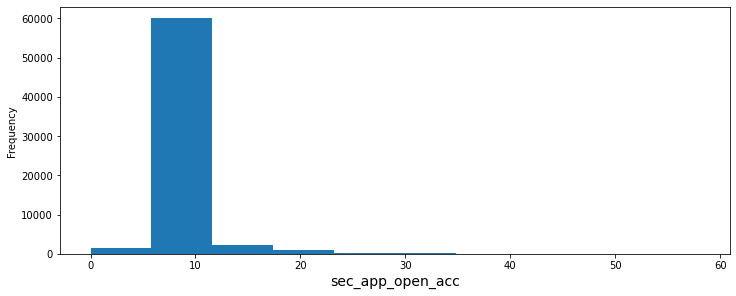



Box plot and histogram for sec_app_open_acc after capping the outliers:



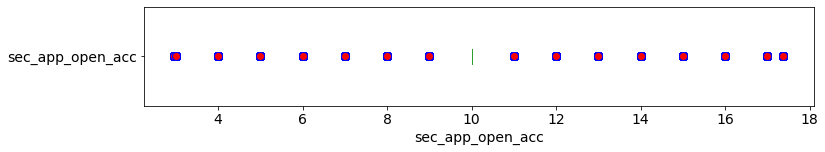

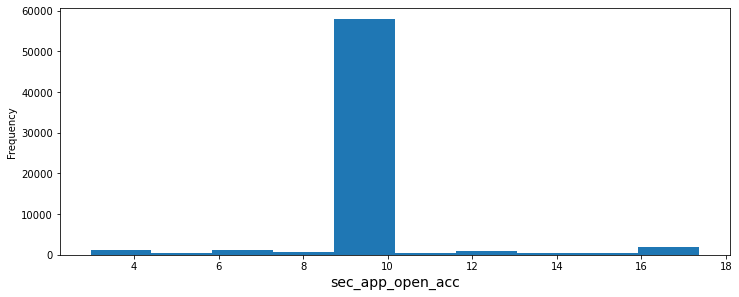


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_open_acc : 2.9689171920196777
Maximum value for sec_app_open_acc : 17.370163179516364


The lower limit for sec_app_revol_util is: 28.964979414825493
The upper limit for sec_app_revol_util is: 87.09113173893206


Box plot and histogram for sec_app_revol_util before capping the outliers:



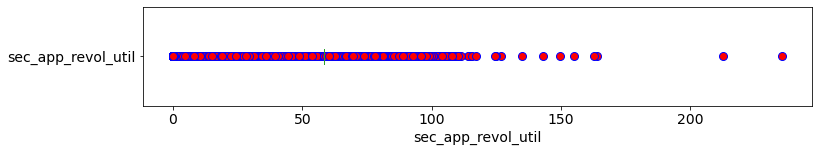

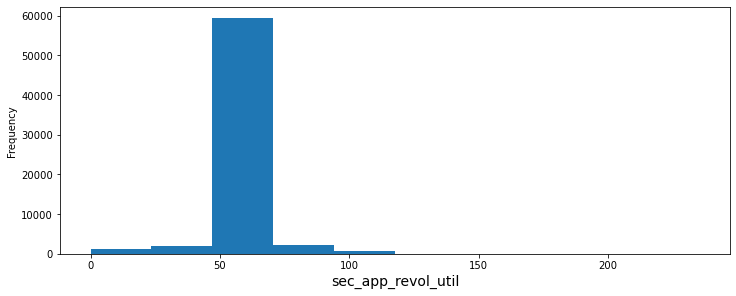



Box plot and histogram for sec_app_revol_util after capping the outliers:



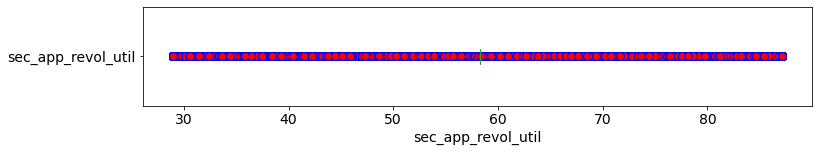

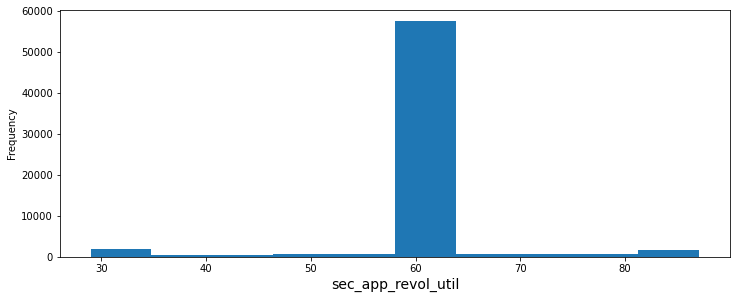


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_revol_util : 28.964979414825493
Maximum value for sec_app_revol_util : 87.09113173893206


The lower limit for sec_app_open_act_il is: -1.389552385778475
The upper limit for sec_app_open_act_il is: 5.628041677250034


Box plot and histogram for sec_app_open_act_il before capping the outliers:



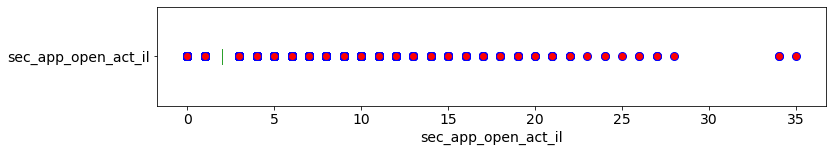

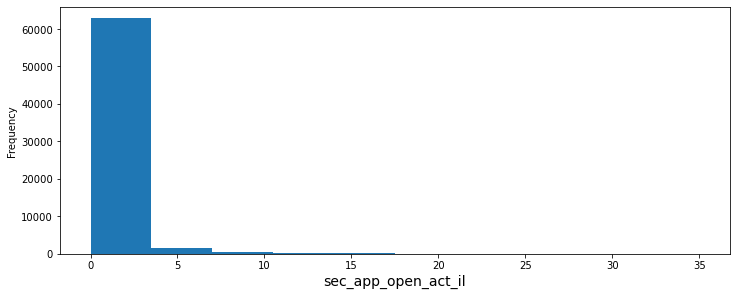



Box plot and histogram for sec_app_open_act_il after capping the outliers:



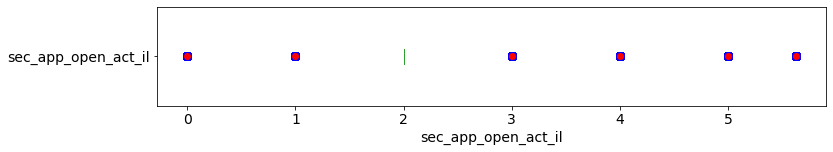

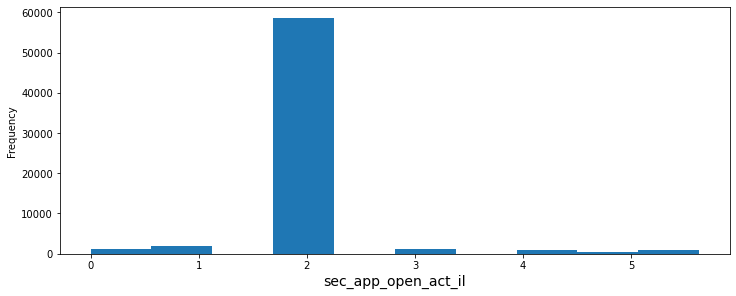


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_open_act_il : 0.0
Maximum value for sec_app_open_act_il : 5.628041677250034


The lower limit for sec_app_num_rev_accts is: 1.9758098551460836
The upper limit for sec_app_num_rev_accts is: 20.47681929968619


Box plot and histogram for sec_app_num_rev_accts before capping the outliers:



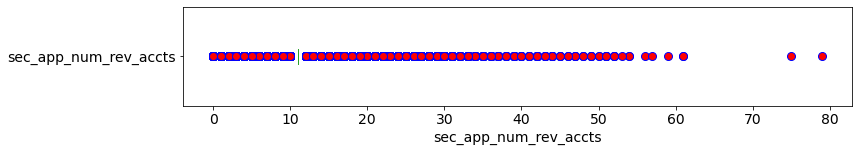

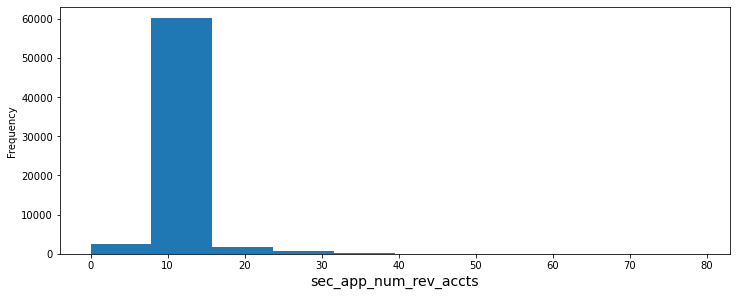



Box plot and histogram for sec_app_num_rev_accts after capping the outliers:



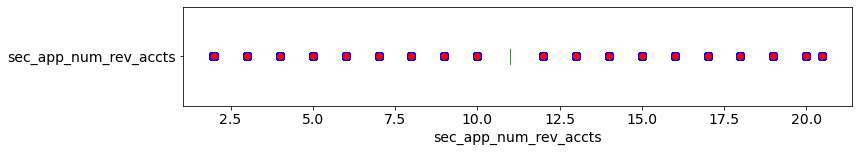

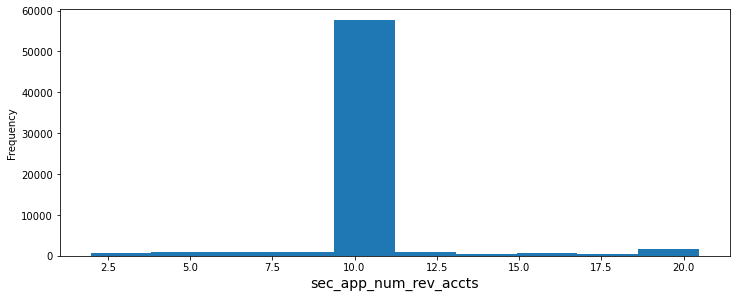


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_num_rev_accts : 1.9758098551460836
Maximum value for sec_app_num_rev_accts : 20.47681929968619


The lower limit for sec_app_chargeoff_within_12_mths is: -0.4915848983452425
The upper limit for sec_app_chargeoff_within_12_mths is: 0.5060164635559588


Box plot and histogram for sec_app_chargeoff_within_12_mths before capping the outliers:



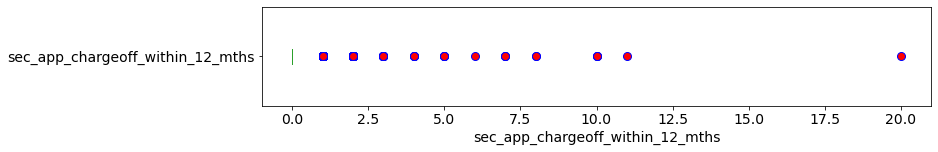

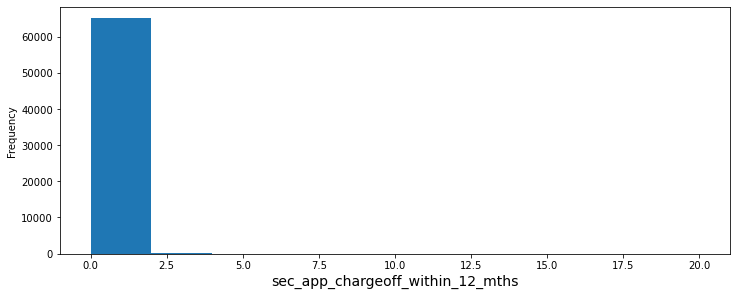



Box plot and histogram for sec_app_chargeoff_within_12_mths after capping the outliers:



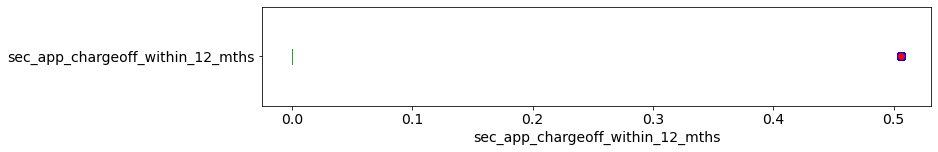

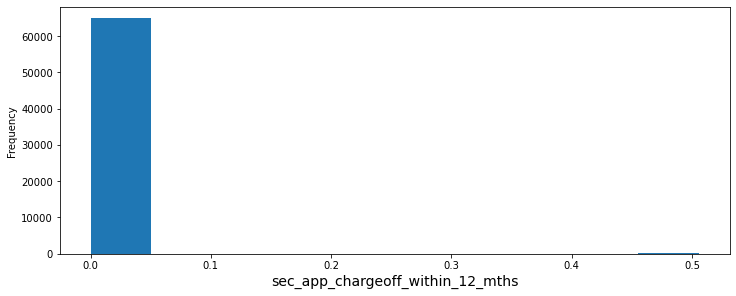


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_chargeoff_within_12_mths : 0.0
Maximum value for sec_app_chargeoff_within_12_mths : 0.5060164635559588


The lower limit for sec_app_collections_12_mths_ex_med is: -0.4175002405826319
The upper limit for sec_app_collections_12_mths_ex_med is: 0.4395774648092382


Box plot and histogram for sec_app_collections_12_mths_ex_med before capping the outliers:



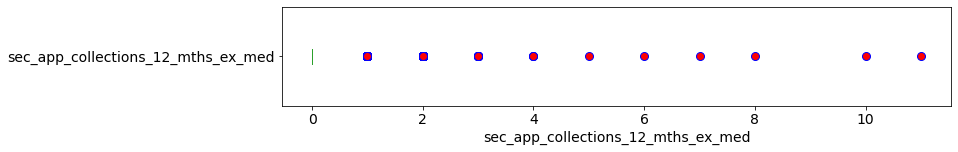

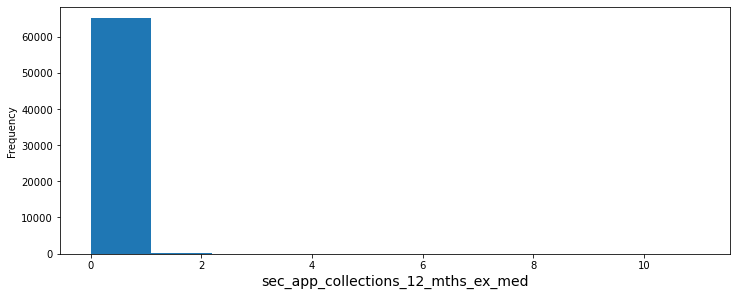



Box plot and histogram for sec_app_collections_12_mths_ex_med after capping the outliers:



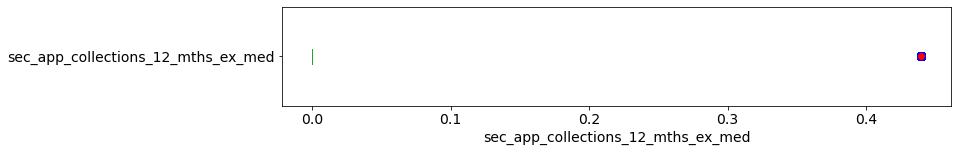

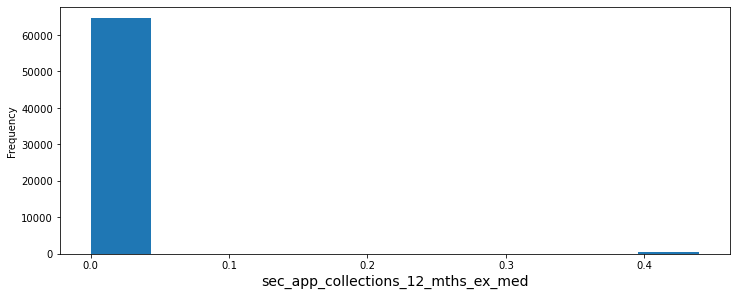


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_collections_12_mths_ex_med : 0.0
Maximum value for sec_app_collections_12_mths_ex_med : 0.4395774648092382


The lower limit for sec_app_mths_since_last_major_derog is: 18.517014523870863
The upper limit for sec_app_mths_since_last_major_derog is: 49.6702273583737


Box plot and histogram for sec_app_mths_since_last_major_derog before capping the outliers:



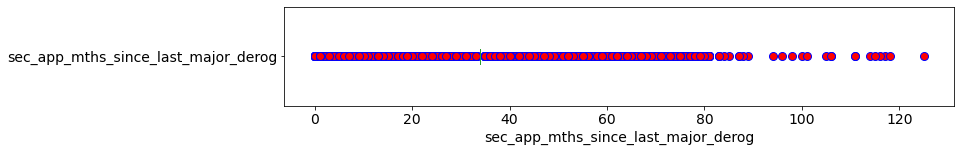

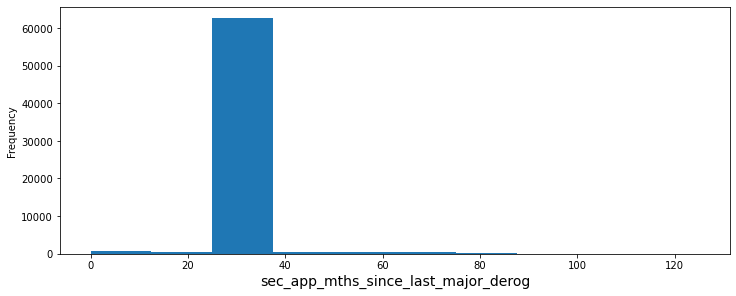



Box plot and histogram for sec_app_mths_since_last_major_derog after capping the outliers:



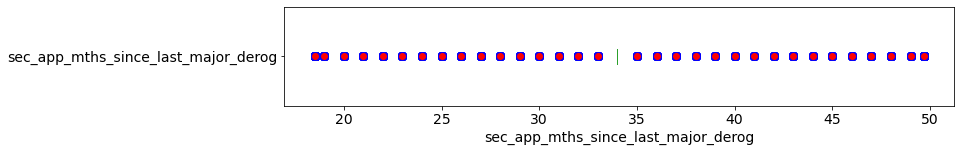

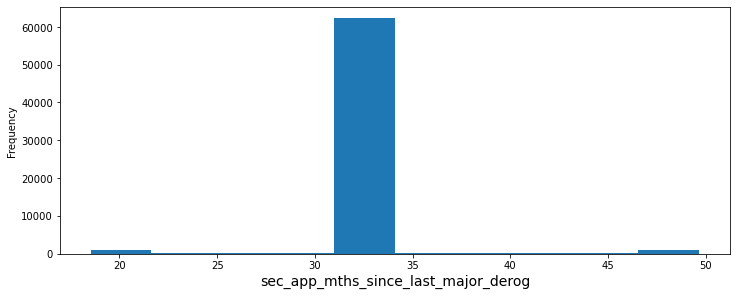


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for sec_app_mths_since_last_major_derog : 18.517014523870863
Maximum value for sec_app_mths_since_last_major_derog : 49.6702273583737


The lower limit for hardship_dpd is: 14.585620559142614
The upper limit for hardship_dpd is: 17.406088967225696


Box plot and histogram for hardship_dpd before capping the outliers:



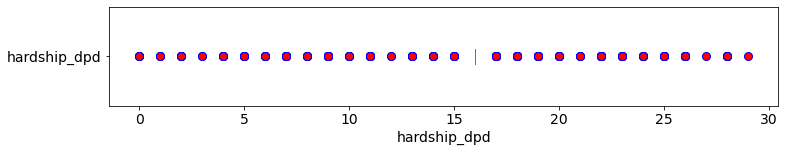

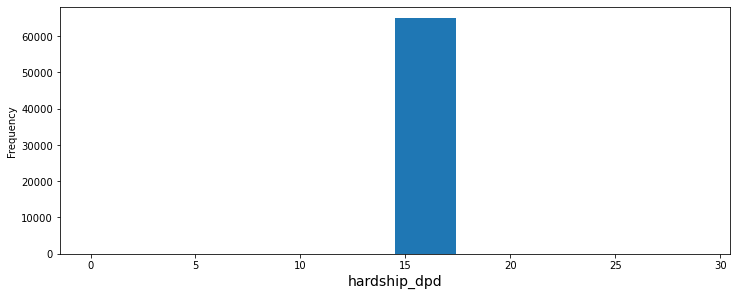



Box plot and histogram for hardship_dpd after capping the outliers:



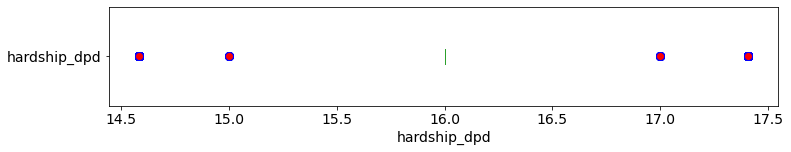

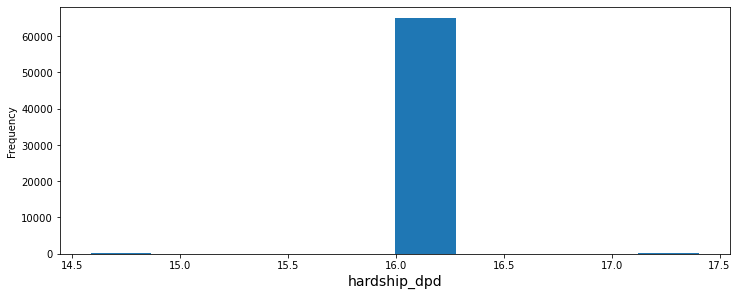


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for hardship_dpd : 14.585620559142614
Maximum value for hardship_dpd : 17.406088967225696


The lower limit for settlement_percentage is: 52.61340690106092
The upper limit for settlement_percentage is: 57.37761052428643


Box plot and histogram for settlement_percentage before capping the outliers:



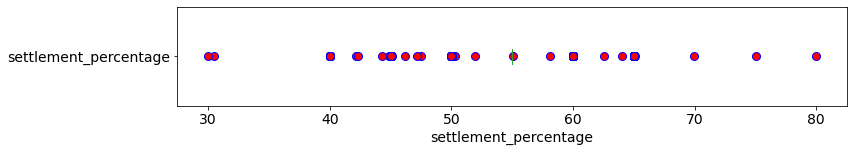

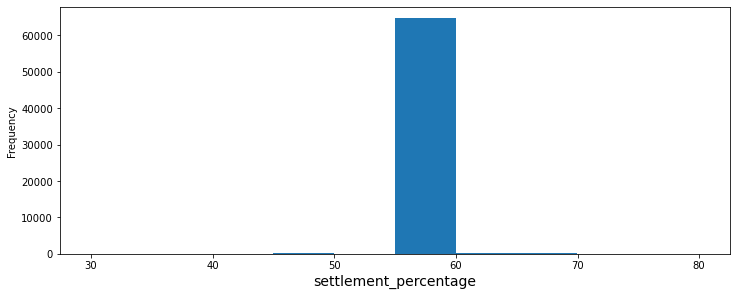



Box plot and histogram for settlement_percentage after capping the outliers:



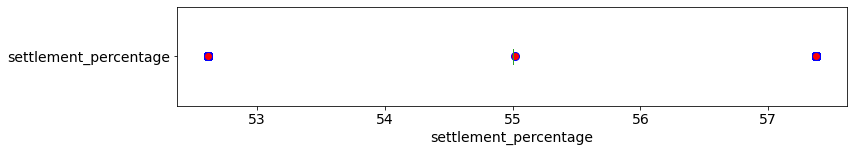

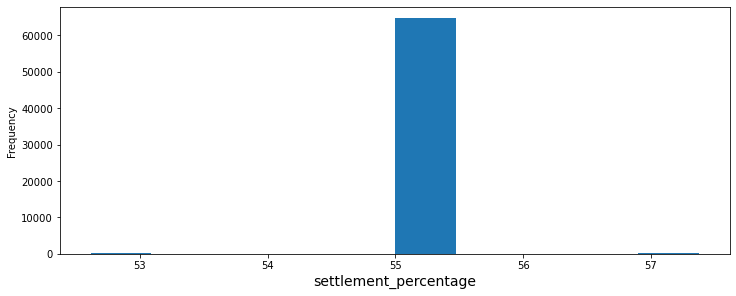


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for settlement_percentage : 52.61340690106092
Maximum value for settlement_percentage : 57.37761052428643


The lower limit for settlement_term is: 16.39679456439938
The upper limit for settlement_term is: 19.60575398860592


Box plot and histogram for settlement_term before capping the outliers:



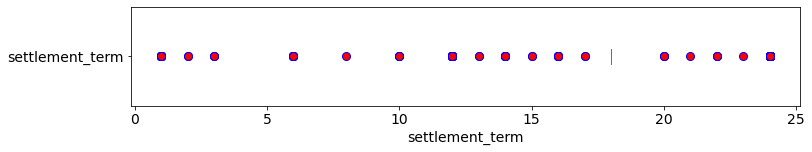

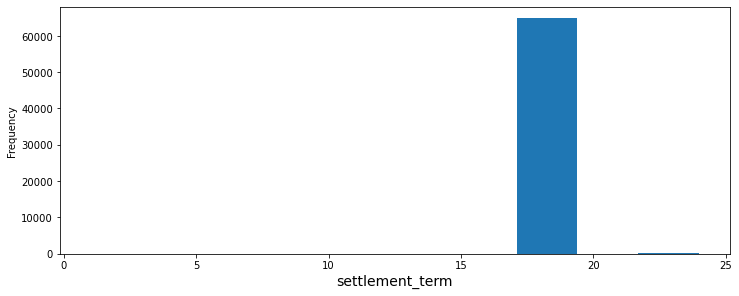



Box plot and histogram for settlement_term after capping the outliers:



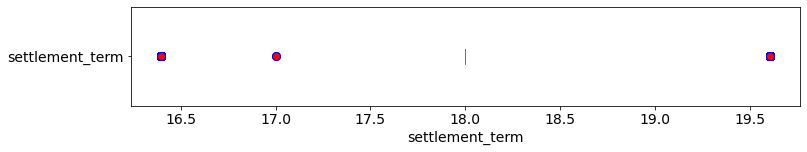

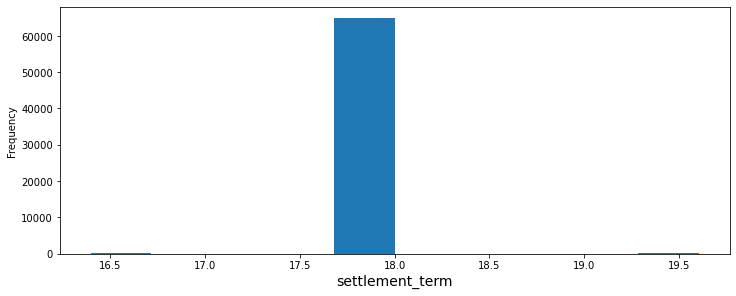


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 113)

Minimum value for settlement_term : 16.39679456439938
Maximum value for settlement_term : 19.60575398860592




In [34]:
# Now I will use the above function on the list of variables below
columns_for_outlier_removal = [['dti'],['revol_util'],['avg_cur_bal'],['bc_open_to_buy'],['bc_util'],['pct_tl_nvr_dlq'],
                               ['percent_bc_gt_75'],['revol_bal_joint'],['hardship_amount'],
                               ['orig_projected_additional_accrued_interest'],['hardship_payoff_balance_amount'],
                               ['hardship_last_payment_amount'],['settlement_amount'],['StateLaborForceParticipationRate'],
                               ['StateEmploymentPopulationRatio'],['StateUnemploymentRate'],['mths_since_last_delinq'],
                               ['mths_since_last_record'],['mths_since_last_major_derog'],['annual_inc_joint'],
                               ['dti_joint'],['mths_since_rcnt_il'],['il_util'],['all_util'],['mo_sin_old_il_acct'],
                               ['mths_since_recent_bc'],['mths_since_recent_bc_dlq'],['mths_since_recent_inq'],
                               ['mths_since_recent_revol_delinq'],['num_tl_120dpd_2m'],['sec_app_fico_range_low'],
                               ['sec_app_fico_range_high'],['sec_app_inq_last_6mths'],['sec_app_mort_acc'],
                               ['sec_app_open_acc'],['sec_app_revol_util'],['sec_app_open_act_il'],
                               ['sec_app_num_rev_accts'],['sec_app_chargeoff_within_12_mths'],
                               ['sec_app_collections_12_mths_ex_med'],['sec_app_mths_since_last_major_derog'],
                               ['hardship_dpd'],['settlement_percentage'],['settlement_term']]

for var in columns_for_outlier_removal:
    find_anomalies(modeling_dataset,var)

In [35]:
# Now that I have removed outliers, I will use Recursive Feature Elimination with Cross Validation (RFECV) to 
#   eliminate features that won't be important for modeling
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# I will first look for correlated features that I can remove prior to running RFECV
correlated_features = set()
correlation_matrix = modeling_dataset.drop('Perf', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print('The correlated features are:',correlated_features)

# Dropping the correlated features
modeling_dataset = modeling_dataset.drop(correlated_features,axis=1)

The correlated features are: {'total_bal_ex_mort', 'tot_hi_cred_lim', 'percent_bc_gt_75', 'num_sats', 'title', 'num_actv_rev_tl', 'fico_range_high', 'avg_cur_bal', 'num_tl_op_past_12m', 'num_rev_accts', 'pub_rec_bankruptcies', 'num_rev_tl_bal_gt_0', 'total_bc_limit', 'last_fico_range_low', 'orig_projected_additional_accrued_interest', 'hardship_flag', 'StateEmploymentPopulationRatio', 'bc_util', 'num_op_rev_tl', 'num_tl_30dpd', 'total_il_high_credit_limit', 'sec_app_fico_range_high', 'hardship_payoff_balance_amount', 'sub_grade', 'acc_open_past_24mths'}


In [36]:
print('\ndf Shape: Number of rows(records), Number of columns(variables)\n',modeling_dataset.shape)


df Shape: Number of rows(records), Number of columns(variables)
 (65135, 88)


In [37]:
# Now that I've gotten this far, I will pickle the state of my modeling dataset again

#create a file
picklefile = open('modeling_df2', 'wb')

#pickle the dataframe
pickle.dump(modeling_dataset, picklefile)

#close file
picklefile.close()

In [38]:
# Now I can unpickle it and continue...(I will be able to resume from this point forward without having to 
#   run all the prior steps)
import pickle

#read the pickle file
picklefile = open('modeling_df2', 'rb')

#unpickle the dataframe
modeling_dataset = pickle.load(picklefile)

#close file
picklefile.close()

In [39]:
# Before running RFECV, I have to generate a smaller random subset of records because otherwise, with the number of 
#   records and variables I have, the process takes hours to run on my machine.

# Using a random subset that is a quarter of the size of the original dataset
sample_subset = modeling_dataset.sample(frac=0.25)
sample_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16284 entries, 76656 to 470612
Data columns (total 88 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   term                                 16284 non-null  int64  
 1   grade                                16284 non-null  int64  
 2   emp_length                           16284 non-null  int32  
 3   home_ownership                       16284 non-null  int32  
 4   annual_inc                           16284 non-null  float64
 5   verification_status                  16284 non-null  int32  
 6   pymnt_plan                           16284 non-null  int32  
 7   purpose                              16284 non-null  int32  
 8   dti                                  16284 non-null  float64
 9   delinq_2yrs                          16284 non-null  float64
 10  fico_range_low                       16284 non-null  float64
 11  inq_last_6mths         

In [40]:
# Now it's time to run Recursive Feature Elimination with Cross Validation (RFECV)
from sklearn.ensemble import RandomForestClassifier
X = sample_subset.drop('Perf', axis=1)
y = sample_subset['Perf']

rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=101), scoring='accuracy')

Optimal number of features: 82


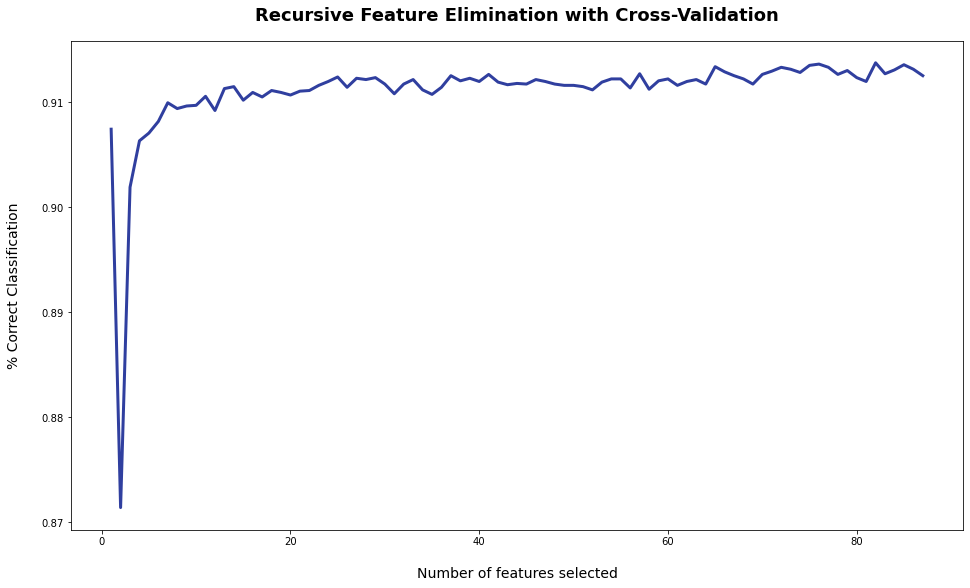

In [41]:
import matplotlib.pyplot as plt
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [42]:
# Printing out which features are considered to be least important and dropping them
import numpy as np
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[27 47 62 65 74]


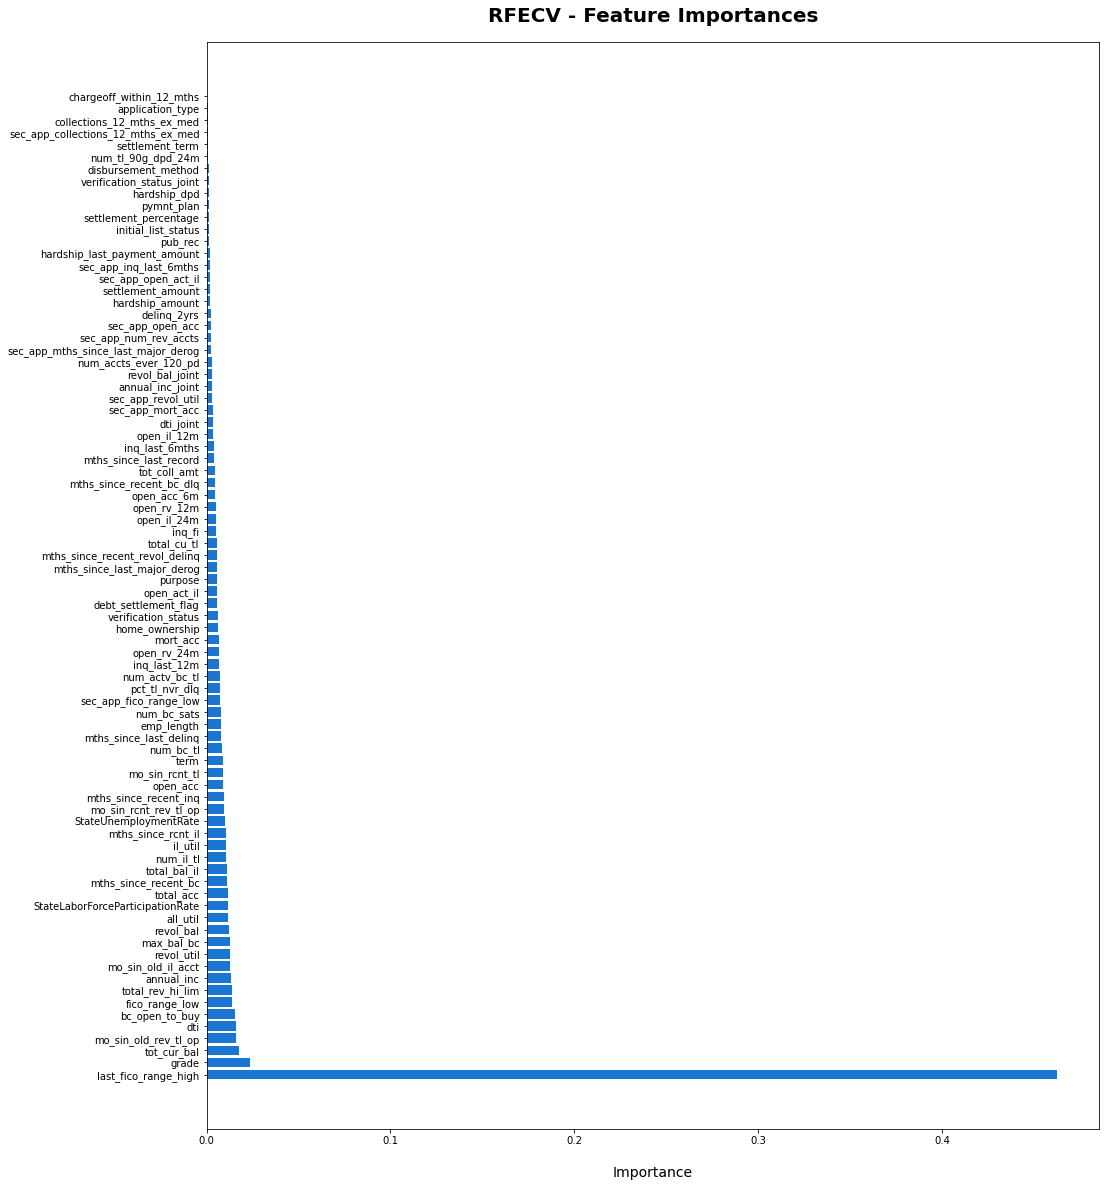

In [43]:
# Getting a visual of the features ordered by importance
import pandas as pd

dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 20))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [44]:
# Now that we've reduced our features set to 82 predictor variables, let's use the full data set with the 82 predictor
#   variables + the Perf variable
model_features = dset['attr'].tolist()
modeling_dataset = pd.concat([modeling_dataset[model_features], modeling_dataset['Perf']],axis=1)

X = modeling_dataset.drop('Perf', axis=1)
y = modeling_dataset['Perf']
print(y)
modeling_dataset.columns[modeling_dataset.isna().any()].tolist()

4         1.0
16        1.0
23        1.0
24        0.0
38        1.0
         ... 
495230    0.0
495231    0.0
495233    1.0
495237    0.0
495238    0.0
Name: Perf, Length: 65135, dtype: float64


[]

In [45]:
# Now that I've gotten this far, I will pickle the state of my modeling dataset again

#create a file
picklefile = open('modeling_df3', 'wb')

#pickle the dataframe
pickle.dump(modeling_dataset, picklefile)

#close file
picklefile.close()

In [46]:
# Now I can unpickle it and continue...(I will be able to resume from this point forward without having to 
#   run all the prior steps)
import pickle

#read the pickle file
picklefile = open('modeling_df3', 'rb')

#unpickle the dataframe
df = pickle.load(picklefile)

#close file
picklefile.close()

In [47]:
# Now we'll start the ML modeling process by splitting the data into training an testing sets:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The accuracy score for the LogisticRegression model is: 0.8989022798802487

The AUC & ROC score for the LogisticRegression model is 0.8427205591748035


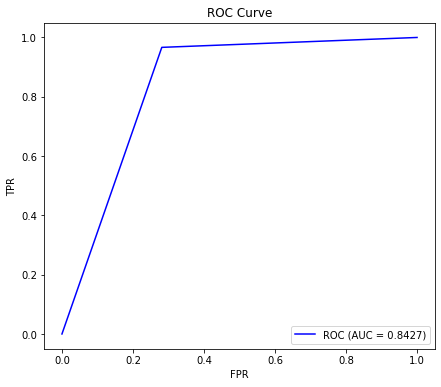

In [48]:
# Now we'll fit a Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy_score(y_test, y_pred)
print('The accuracy score for the LogisticRegression model is:',accuracy_score(y_test, y_pred))
print('\nThe AUC & ROC score for the LogisticRegression model is',roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

The accuracy score for the RandomForestClassifier model is: 0.9037383894987334

The AUC & ROC score for the RandomForestClassifier model is 0.8499914546449344


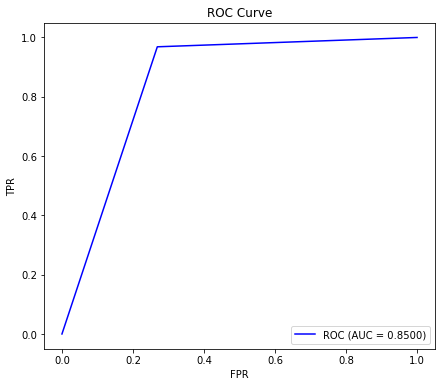

In [49]:
# Now we'll fit a Random Forest model
clf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('The accuracy score for the RandomForestClassifier model is:',accuracy_score(y_test, y_pred))
print('\nThe AUC & ROC score for the RandomForestClassifier model is',roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

The accuracy score for the XGBClassifier model is: 0.9048130805250634

The AUC & ROC score for the RandomForestClassifier model is 0.8566023697931192


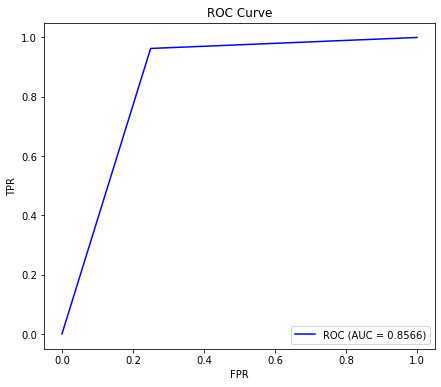

In [50]:
# Now we'll fit an XGBoost model
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('The accuracy score for the XGBClassifier model is:',accuracy_score(y_test, y_pred))
print('\nThe AUC & ROC score for the XGBClassifier model is',roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [60]:
# Now we are going to tune the hyperparameters on the XGBClassifier model
XGBtest1 = {'learning_rate':[0.1,0.05,0.01,0.005], 'n_estimators':[50,100,150,200]}

tuning = GridSearchCV(estimator=XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
            param_grid=test1, scoring='accuracy',n_jobs=4, cv=5)

tuning.fit(X_train,y_train)

print('\nTuned XGBClassifier  parameters:',tuning.best_params_)
print('\nThe best score is:',tuning.best_score_)


Tuned XGBClassifier  parameters: {'learning_rate': 0.1, 'n_estimators': 200}

The best score is: 0.9134681363456659


In [61]:
# Based on the above results for the tuned parameters learning_rate and n_estimators, we will now tune on max_depth. We will
#   set learning_rate to 0.1 and n_estimators to 200
XGBtest2 = {'max_depth':[2,3,4,5,6,7] }

tuning = GridSearchCV(estimator=XGBClassifier(learning_rate=0.1,n_estimators=200, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid=XGBtest2, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(X_train,y_train)

print('\nTuned XGBClassifier parameters:',tuning.best_params_)
print('\nThe best score is:',tuning.best_score_)

[15:55:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Tuned XGBClassifier parameters: {'max_depth': 4}

The best score is: 0.9141398329705319


Accuracy of the GBM on test set: 0.905
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      3560
         1.0       0.91      0.97      0.94      9467

    accuracy                           0.90     13027
   macro avg       0.90      0.85      0.87     13027
weighted avg       0.90      0.90      0.90     13027

The accuracy score for the GradientBoosting model is: 0.904506025946112

The AUC & ROC score for the RandomForestClassifier model is 0.8510454114410436


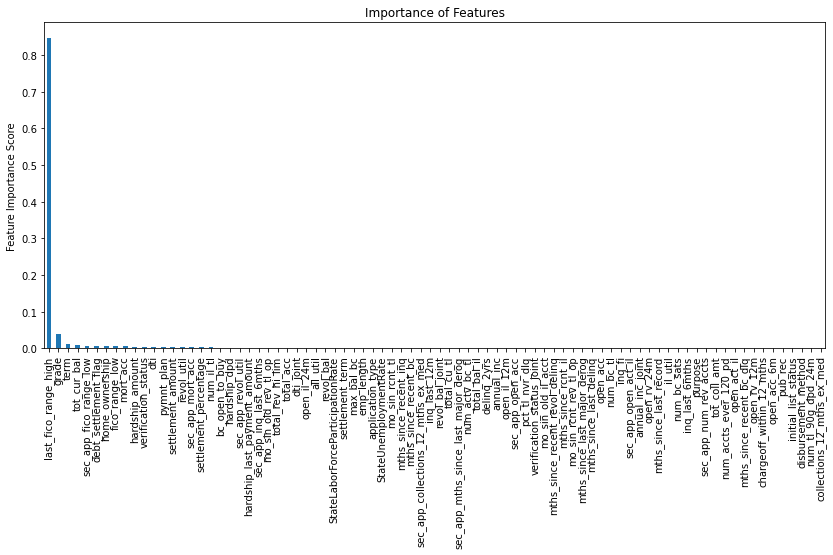

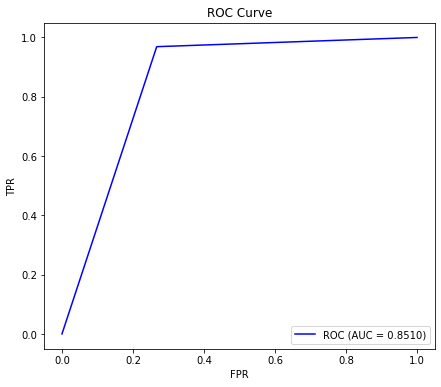

In [51]:
# Now we'll fit a GradientBoosting model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
predictors=list(X_train)
feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
plt.figure(figsize=(14, 6))
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(clf.score(X_test, y_test)))
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

print('The accuracy score for the GradientBoostingClassifier model is:',accuracy_score(y_test, y_pred))
print('\nThe AUC & ROC score for the GradientBoostingClassifier model is',roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='blue',label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


In [58]:
# Now we are going to tune the hyperparameters on the GradientBoosting model
test1 = {'learning_rate':[0.1,0.05,0.01,0.005], 'n_estimators':[50,100,150,200]}

tuning = GridSearchCV(estimator=GradientBoostingClassifier(max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid=test1, scoring='accuracy',n_jobs=4, cv=5)

tuning.fit(X_train,y_train)

print('\nTuned GradientBoostingClassifier parameters:',tuning.best_params_)
print('\nThe best score is:',tuning.best_score_)



Tuned GradientBoostingClassifier parameters: {'learning_rate': 0.1, 'n_estimators': 200}

The best score is: 0.9125085907843223


In [59]:
# Based on the above results for the tuned parameters learning_rate and n_estimators, we will now tune on max_depth. We will
#   set learning_rate to 0.1 and n_estimators to 200
test2 = {'max_depth':[2,3,4,5,6,7] }

tuning = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1,n_estimators=200, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid=test2, scoring='accuracy', n_jobs=4, cv=5)

tuning.fit(X_train,y_train)

print('\nTuned GradientBoostingClassifier parameters:',tuning.best_params_)
print('\nThe best score is:',tuning.best_score_)


Tuned GradientBoostingClassifier parameters: {'max_depth': 5}

The best score is: 0.9130843218041098


# CONCLUSION: 
## The best performing model was indeed the XGBoost model, not only after hyperparameter tuning, but also straight out of the box.